<a href="https://colab.research.google.com/github/Vale864/Causal_Impact_Airline_Fare/blob/main/airline_counterfactual_trend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Data

In [1]:
!pip install preliz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 529.2/529.2 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.0/149.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.2 MB/s eta 0:00:00
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.43.0
    Uninstalling llvmlite-0.43.0:
      Successfully uninstalled llvmlite-0.43.0
  Attempting uninstall: numba
    Found existing installation: numba 0.60.0
    Uninstalling numba-0.60.0:
      Successfully uninstalled numba-0.60.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cuml-cu12 25.10.0 requires numba<0.62.0a0,>=0.60.0, but you have numba 0.62.1 which is incompatible.
cudf-cu12 25.10.0 requires numba<0.62.0a0,>=0.60.0, but you have numba 0.62.1 which is incompa

In [2]:
from google.colab import drive
drive.mount('/content/drive')
print("✅ Google Drive mounted successfully.")

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pymc as pm
import arviz as az
import preliz as pz
import pytensor.tensor as pt
import xarray as xr

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plots_folder = '/content/drive/MyDrive/AirlineData/counterfactual_trend_plots'
os.makedirs(plots_folder, exist_ok=True)

models_folder = '/content/drive/MyDrive/AirlineData/counterfactual_trend_models'
os.makedirs(models_folder, exist_ok=True)

print("✅ Environment setup complete. All libraries are installed and imported.")

Mounted at /content/drive
✅ Google Drive mounted successfully.
✅ Environment setup complete. All libraries are installed and imported.


In [3]:
FINAL_DATAFRAMES_DIR = '/content/drive/My Drive/AirlineData/processed_tables'
dtw_fll_path = os.path.join(FINAL_DATAFRAMES_DIR, 'dtw_fll_df.parquet')

try:
    dtw_fll_df = pd.read_parquet(dtw_fll_path)
    print(f"✅ Imported DataFrame as: {dtw_fll_path}")
except Exception as e:
    print(f"❌ Error Importing: {e}")

display(dtw_fll_df.info())

✅ Imported DataFrame as: /content/drive/My Drive/AirlineData/processed_tables/dtw_fll_df.parquet
<class 'pandas.core.frame.DataFrame'>
Index: 79114 entries, 11625029 to 112585946
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype        
---  ------              --------------  -----        
 0   ItinID              79114 non-null  uint32       
 1   MktID               79114 non-null  uint32       
 2   MktCoupons          79114 non-null  uint8        
 3   Year                79114 non-null  uint16       
 4   Quarter             79114 non-null  uint8        
 5   Origin              79114 non-null  object       
 6   OriginState         79114 non-null  object       
 7   Dest                79114 non-null  object       
 8   DestState           79114 non-null  object       
 9   OpCarrierChange     79114 non-null  uint8        
 10  RPCarrier           79114 non-null  category     
 11  OpCarrier           79114 non-null  object       
 12  Passengers   

None

## Helper Functions

In [4]:
def add_time_index(df):
    """Combines time columns into a single column"""
    df_copy = df.copy()
    df_copy['Time_Numeric'] = df_copy['Year'].astype('float') + ((df_copy['Quarter'] - 1) * .25)
    return df_copy

def combine_low_count_carriers(df):
    """Combines low count carriers to simplify aggregation later on"""
    df['RPCarrier'] = np.where(
                               df['RPCarrier'].isin(['DL', 'NK']),
                               df['RPCarrier'],
                               'Other_Carriers'
    )
    return df

def aggregate_quarter_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Aggregates transaction-level data to the Carrier-Time level,
    calculating passenger-weighted yield and market share.
    """
    aggregation_dict = {'Revenue': 'sum', 'Passengers': 'sum'}

    groupby_cols = ['RPCarrier', 'Year', 'Quarter', 'Time_Numeric', 'QuarterPeriod']

    aggregated_data = (
        df.groupby(groupby_cols, observed=True)
        .agg(aggregation_dict)
        .reset_index()
        .rename(columns={'Revenue': 'Quarter_Revenue_sum',
                         'Passengers': 'Quarter_Carrier_Passengers_sum'})
    )

    valid_pass_mask = aggregated_data['Quarter_Carrier_Passengers_sum'] > 0
    aggregated_data['Quarter_Yield_mean'] = 0.0

    aggregated_data.loc[valid_pass_mask, 'Quarter_Yield_mean'] = (
        aggregated_data.loc[valid_pass_mask, 'Quarter_Revenue_sum'] /
        aggregated_data.loc[valid_pass_mask, 'Quarter_Carrier_Passengers_sum']
    )

    market_share_groupby_cols = ['Year', 'Quarter']

    total_passengers = aggregated_data.groupby(
        market_share_groupby_cols, observed=True
    )['Quarter_Carrier_Passengers_sum'].transform('sum')

    aggregated_data['Total_Passengers'] = total_passengers

    aggregated_data['Quarter_Market_Share'] = 0.0
    valid_share_mask = aggregated_data['Total_Passengers'] > 0

    aggregated_data.loc[valid_share_mask, 'Quarter_Market_Share'] = (
        aggregated_data.loc[valid_share_mask, 'Quarter_Carrier_Passengers_sum'] /
        aggregated_data.loc[valid_share_mask, 'Total_Passengers']
    )

    return aggregated_data[
                           ['RPCarrier', 'Year', 'Quarter', 'Time_Numeric', 'QuarterPeriod',
                           'Quarter_Revenue_sum',
                           'Quarter_Yield_mean',
                           'Quarter_Market_Share',
                           'Quarter_Carrier_Passengers_sum']
    ]

def market_aggregate_quantile_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Aggregates transaction-level data to the Carrier-Time-Quantile level,
    calculating passenger-weighted yield and market share *within that quantile*.
    """
    aggregation_dict = {'Revenue': 'sum','Passengers': 'sum'}

    groupby_cols = ['RPCarrier', 'Year', 'Quarter', 'Time_Numeric', 'Quantile_id']

    aggregated_data = (
        df.groupby(groupby_cols, observed=True)
        .agg(aggregation_dict)
        .reset_index()
        .rename(columns={'Revenue': 'Market_Quantile_Revenue_sum',
                         'Passengers': 'Market_Quantile_Carrier_Passengers'})
    )

    valid_pass_mask = aggregated_data['Market_Quantile_Carrier_Passengers'] > 0
    aggregated_data['Market_Quantile_Yield'] = 0.0

    aggregated_data.loc[valid_pass_mask, 'Market_Quantile_Yield'] = (
        aggregated_data.loc[valid_pass_mask, 'Market_Quantile_Revenue_sum'] /
        aggregated_data.loc[valid_pass_mask, 'Market_Quantile_Carrier_Passengers']
    )

    market_share_groupby_cols = ['Year', 'Quarter', 'Time_Numeric', 'Quantile_id']

    total_passengers = aggregated_data.groupby(
        market_share_groupby_cols, observed=True
    )['Market_Quantile_Carrier_Passengers'].transform('sum')

    aggregated_data['Quantile_Total_Passengers'] = total_passengers

    aggregated_data['Market_Quantile_Share'] = 0.0
    valid_share_mask = aggregated_data['Quantile_Total_Passengers'] > 0

    aggregated_data.loc[valid_share_mask, 'Market_Quantile_Share'] = (
        aggregated_data.loc[valid_share_mask, 'Market_Quantile_Carrier_Passengers'] /
        aggregated_data.loc[valid_share_mask, 'Quantile_Total_Passengers']
    )

    return aggregated_data[
                           ['RPCarrier', 'Year', 'Quarter', 'Time_Numeric',
                            'Quantile_id',
                            'Market_Quantile_Revenue_sum',
                            'Market_Quantile_Yield',
                            'Market_Quantile_Share',
                            'Market_Quantile_Carrier_Passengers']
    ]

def carrier_aggregate_quantile_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Aggregates transaction-level data to the Carrier-Time-Quantile level,
    calculating the passenger-weighted yield.
    """
    aggregation_dict = {'Revenue': 'sum', 'Passengers': 'sum'}

    groupby_cols = ['RPCarrier', 'Year', 'Quarter', 'Time_Numeric', 'Quantile_id']

    aggregated_data = (
        df.groupby(groupby_cols, observed=True)
        .agg(aggregation_dict)
        .reset_index()
        .rename(columns={'Revenue': 'Carrier_Quantile_Revenue_sum',
                         'Passengers': 'Carrier_Quantile_Passengers_sum'})
    )

    valid_pass_mask = aggregated_data['Carrier_Quantile_Passengers_sum'] > 0
    aggregated_data['Carrier_Quantile_Yield'] = 0.0

    aggregated_data.loc[valid_pass_mask, 'Carrier_Quantile_Yield'] = (
        aggregated_data.loc[valid_pass_mask, 'Carrier_Quantile_Revenue_sum'] /
        aggregated_data.loc[valid_pass_mask, 'Carrier_Quantile_Passengers_sum']
    )

    return aggregated_data[
                           ['RPCarrier', 'Year', 'Quarter', 'Time_Numeric',
                            'Quantile_id',
                            'Carrier_Quantile_Revenue_sum',
                            'Carrier_Quantile_Yield',]
    ]

def add_quantile_ind(df):
    """Bins 'Yield' based on pre-calculated quantile columns."""
    conditions = [
        df['Yield'] < df['10'],
        (df['10'] <= df['Yield']) & (df['Yield'] < df['20']),
        (df['20'] <= df['Yield']) & (df['Yield'] < df['30']),
        (df['30'] <= df['Yield']) & (df['Yield'] < df['40']),
        (df['40'] <= df['Yield']) & (df['Yield'] < df['50']),
        (df['50'] <= df['Yield']) & (df['Yield'] < df['60']),
        (df['60'] <= df['Yield']) & (df['Yield'] < df['70']),
        (df['70'] <= df['Yield']) & (df['Yield'] < df['80']),
        (df['80'] <= df['Yield']) & (df['Yield'] < df['90']),
        df['90'] <= df['Yield']
    ]
    options = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]

    df['Quantile_id'] = np.select(
        conditions,
        options,
        default=np.nan
    )
    return df


def get_agg_quantile_df(df):
    """
    Orchestrates the full aggregation pipeline
    """
    df_copy = df.copy()
    df_copy = add_time_index(df_copy)
    df_copy = combine_low_count_carriers(df_copy)

    df_copy['Revenue'] = df_copy['Yield'] * df_copy['Passengers']

    quantile_list = [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90]
    market_quantile_groupby_cols = ['Year', 'Quarter', 'Time_Numeric']
    carrier_quantile_groupby_cols = ['RPCarrier', 'Year', 'Quarter', 'Time_Numeric', 'QuarterPeriod']

    market_quantile_group_df = (
        df_copy.groupby(market_quantile_groupby_cols, observed=True)['Yield']
        .quantile(quantile_list)
        .unstack()
        .rename(columns=lambda x: f"{int(x*100)}")
        .reset_index()
    )
    carrier_quantile_group_df = (
        df_copy.groupby(carrier_quantile_groupby_cols, observed=True)['Yield']
        .quantile(quantile_list)
        .unstack()
        .rename(columns=lambda x: f"{int(x*100)}")
        .reset_index()
    )

    market_quantile_df = pd.merge(
        df_copy,
        market_quantile_group_df,
        on=market_quantile_groupby_cols,
        how='left'
    )
    carrier_quantile_df = pd.merge(
        df_copy,
        carrier_quantile_group_df,
        on=carrier_quantile_groupby_cols,
        how='left'
    )

    market_quantile_df = add_quantile_ind(market_quantile_df)
    carrier_quantile_df = add_quantile_ind(carrier_quantile_df)

    agg_market_quantile_df = market_aggregate_quantile_data(market_quantile_df)
    agg_carrier_quantile_df = carrier_aggregate_quantile_data(carrier_quantile_df)
    agg_quarter_df = aggregate_quarter_data(market_quantile_df)

    quantile_quarter_df = pd.merge(
        agg_carrier_quantile_df,
        agg_quarter_df,
        on = ['RPCarrier',  'Year', 'Quarter',  'Time_Numeric'],
        how='left'
    )
    market_carrier_qn_qr_df = pd.merge(
        quantile_quarter_df,
        agg_market_quantile_df,
        on = ['RPCarrier',  'Year', 'Quarter',  'Time_Numeric', 'Quantile_id'],
        how='left'
    )

    market_carrier_qn_qr_df['Pseudo_Time'] = (
        market_carrier_qn_qr_df['Time_Numeric']
        + market_carrier_qn_qr_df['Quantile_id'] / 10000
    )

    market_carrier_qn_qr_df['Market_Quantile_Percent_Carrier'] = 0.0
    valid_mask = market_carrier_qn_qr_df['Quarter_Carrier_Passengers_sum'] > 0

    market_carrier_qn_qr_df.loc[valid_mask, 'Market_Quantile_Percent_Carrier'] = (
        market_carrier_qn_qr_df.loc[valid_mask, 'Market_Quantile_Carrier_Passengers'] /
        market_carrier_qn_qr_df.loc[valid_mask, 'Quarter_Carrier_Passengers_sum']
    )

    print('df_copy shape:', df_copy.shape)
    print('market_quantile_df shape: ', market_quantile_df.shape)
    print('carrier_quantile_df shape: ', market_quantile_df.shape)
    print('agg_market_quantile_df shape: ', agg_market_quantile_df.shape)
    print('agg_carrier_quantile_df shape: ', agg_carrier_quantile_df.shape)
    print('agg_quarter_df shape: ', agg_quarter_df.shape)
    print('market_carrier_qn_qr_df shape: ', market_carrier_qn_qr_df.shape)

    return market_carrier_qn_qr_df, agg_quarter_df

In [5]:
def ZeroSumNormal(name, *, sigma=None, active_dims=None, dims, model=None):
    model = pm.modelcontext(model=model)

    if isinstance(dims, str):
        dims = [dims]

    if isinstance(active_dims, str):
        active_dims = [active_dims]

    if active_dims is None:
        active_dims = dims[-1]

    def extend_axis(value, axis):
        n_out = value.shape[axis] + 1
        sum_vals = value.sum(axis, keepdims=True)
        norm = sum_vals / (pt.sqrt(n_out) + n_out)
        fill_val = norm - sum_vals / pt.sqrt(n_out)
        out = pt.concatenate([value, fill_val], axis=axis)
        return out - norm

    dims_reduced = []
    active_axes = []
    for i, dim in enumerate(dims):
        if dim in active_dims:
            active_axes.append(i)
            dim_name = f"{dim}_reduced"
            if name not in model.coords:
                model.add_coord(dim_name, length=len(model.coords[dim]) - 1)
            dims_reduced.append(dim_name)
        else:
            dims_reduced.append(dim)

    raw = pm.Normal(f"{name}_raw", sigma=sigma, dims=dims_reduced)
    for axis in active_axes:
        raw = extend_axis(raw, axis)
    return pm.Deterministic(name, raw, dims=dims)

def plot_xY(time_label, x, Y, ax):
    quantiles = Y.quantile((0.025, 0.25, 0.5, 0.75, 0.975), dim=("chain", "draw")).transpose()

    az.plot_hdi(
        x,
        hdi_data=quantiles.sel(quantile=[0.025, 0.975]),
        fill_kwargs={"alpha": 0.25, "label": "95% HDI"},
        smooth=False,
        ax=ax,
    )
    az.plot_hdi(
        x,
        hdi_data=quantiles.sel(quantile=[0.25, 0.75]),
        fill_kwargs={"alpha": 0.5, "label": "50% HDI"},
        smooth=False,
        ax=ax,
    )
    ax.plot(x, quantiles.sel(quantile=0.5), color="C1", lw=3, label="Median")

    step=10
    ax.set_xticks(x[::step])
    ax.set_xticklabels(time_label[::step], rotation=45, ha='right')
    ax.set_xlabel("Time")

## Data Processing

In [6]:
agg_quantile_fll_df, agg_quarter_fll_df = get_agg_quantile_df(dtw_fll_df)

df_copy shape: (79114, 23)
market_quantile_df shape:  (79114, 33)
carrier_quantile_df shape:  (79114, 33)
agg_market_quantile_df shape:  (808, 9)
agg_carrier_quantile_df shape:  (810, 7)
agg_quarter_df shape:  (81, 9)
market_carrier_qn_qr_df shape:  (810, 18)


In [7]:
# We can replace these NaNs with zeros
display(agg_quantile_fll_df[agg_quantile_fll_df.isnull().any(axis=1)])

RPCarrier  Year  Quarter  Time_Numeric  Quantile_id  \
468        NK  2013        3       2013.50         80.0   
477        NK  2013        4       2013.75         70.0   

     Carrier_Quantile_Revenue_sum  Carrier_Quantile_Yield QuarterPeriod  \
468                     12.602908                0.135515        2013Q3   
477                     18.023224                0.130603        2013Q4   

     Quarter_Revenue_sum  Quarter_Yield_mean  Quarter_Market_Share  \
468           116.190318            0.096025              0.323703   
477           132.141118            0.108579              0.221393   

     Quarter_Carrier_Passengers_sum  Market_Quantile_Revenue_sum  \
468                            1210                          NaN   
477                            1217                          NaN   

     Market_Quantile_Yield  Market_Quantile_Share  \
468                    NaN                    NaN   
477                    NaN                    NaN   

     Market_Quantile_Carrier_Passengers  Pseudo_Time  \
468                                 NaN     2013.508   
477                                 NaN     2013.757   

     Market_Quantile_Percent_Carrier  
468                              NaN  
477                              NaN

In [8]:
clean_quant_fll_df = agg_quantile_fll_df.copy()
clean_quant_fll_df = clean_quant_fll_df.fillna(0)
clean_quant_fll_df['Treatment_Period'] = (
    (clean_quant_fll_df['Time_Numeric'] >= 2012) # Corresponds to Q1 of 2012
)
clean_quant_fll_df['Quantile_id'] = (
    clean_quant_fll_df['Quantile_id']
    .astype('int')
    // 10
)
clean_quant_fll_df['Quarter_id'] = (
    clean_quant_fll_df['Quarter'] - 1
)
clean_quant_fll_df['Time_Str'] = (
    clean_quant_fll_df['QuarterPeriod'].astype('str')
)


dl_data = (
    clean_quant_fll_df[clean_quant_fll_df['RPCarrier']=='DL']
    .sort_values(by='Pseudo_Time')
    .reset_index(drop=True)
)
nk_data = (
    clean_quant_fll_df[clean_quant_fll_df['RPCarrier']=='NK']
    .sort_values(by='Pseudo_Time')
    .reset_index(drop=True)
)
other_data = (
    clean_quant_fll_df[clean_quant_fll_df['RPCarrier']=='Other_Carriers']
    .sort_values(by='Pseudo_Time')
    .reset_index(drop=True)
)

pre_fll_df = clean_quant_fll_df[clean_quant_fll_df['Treatment_Period'] == 0]

pre_dl_fll_df = dl_data[dl_data['Treatment_Period'] == 0]
post_dl_fll_df = dl_data[dl_data['Treatment_Period'] == 1]

pre_nk_fll_df = nk_data[nk_data['Treatment_Period'] == 0]
post_nk_fll_df = nk_data[nk_data['Treatment_Period'] == 1]

## Visualise Data

Here I check for structural changes in our treated units over time which could lead to confounding. We can see that for the most part Delta and Spirit have comparable `MktMilesFlown` and `MktCoupons` on the DFW-FLL route.

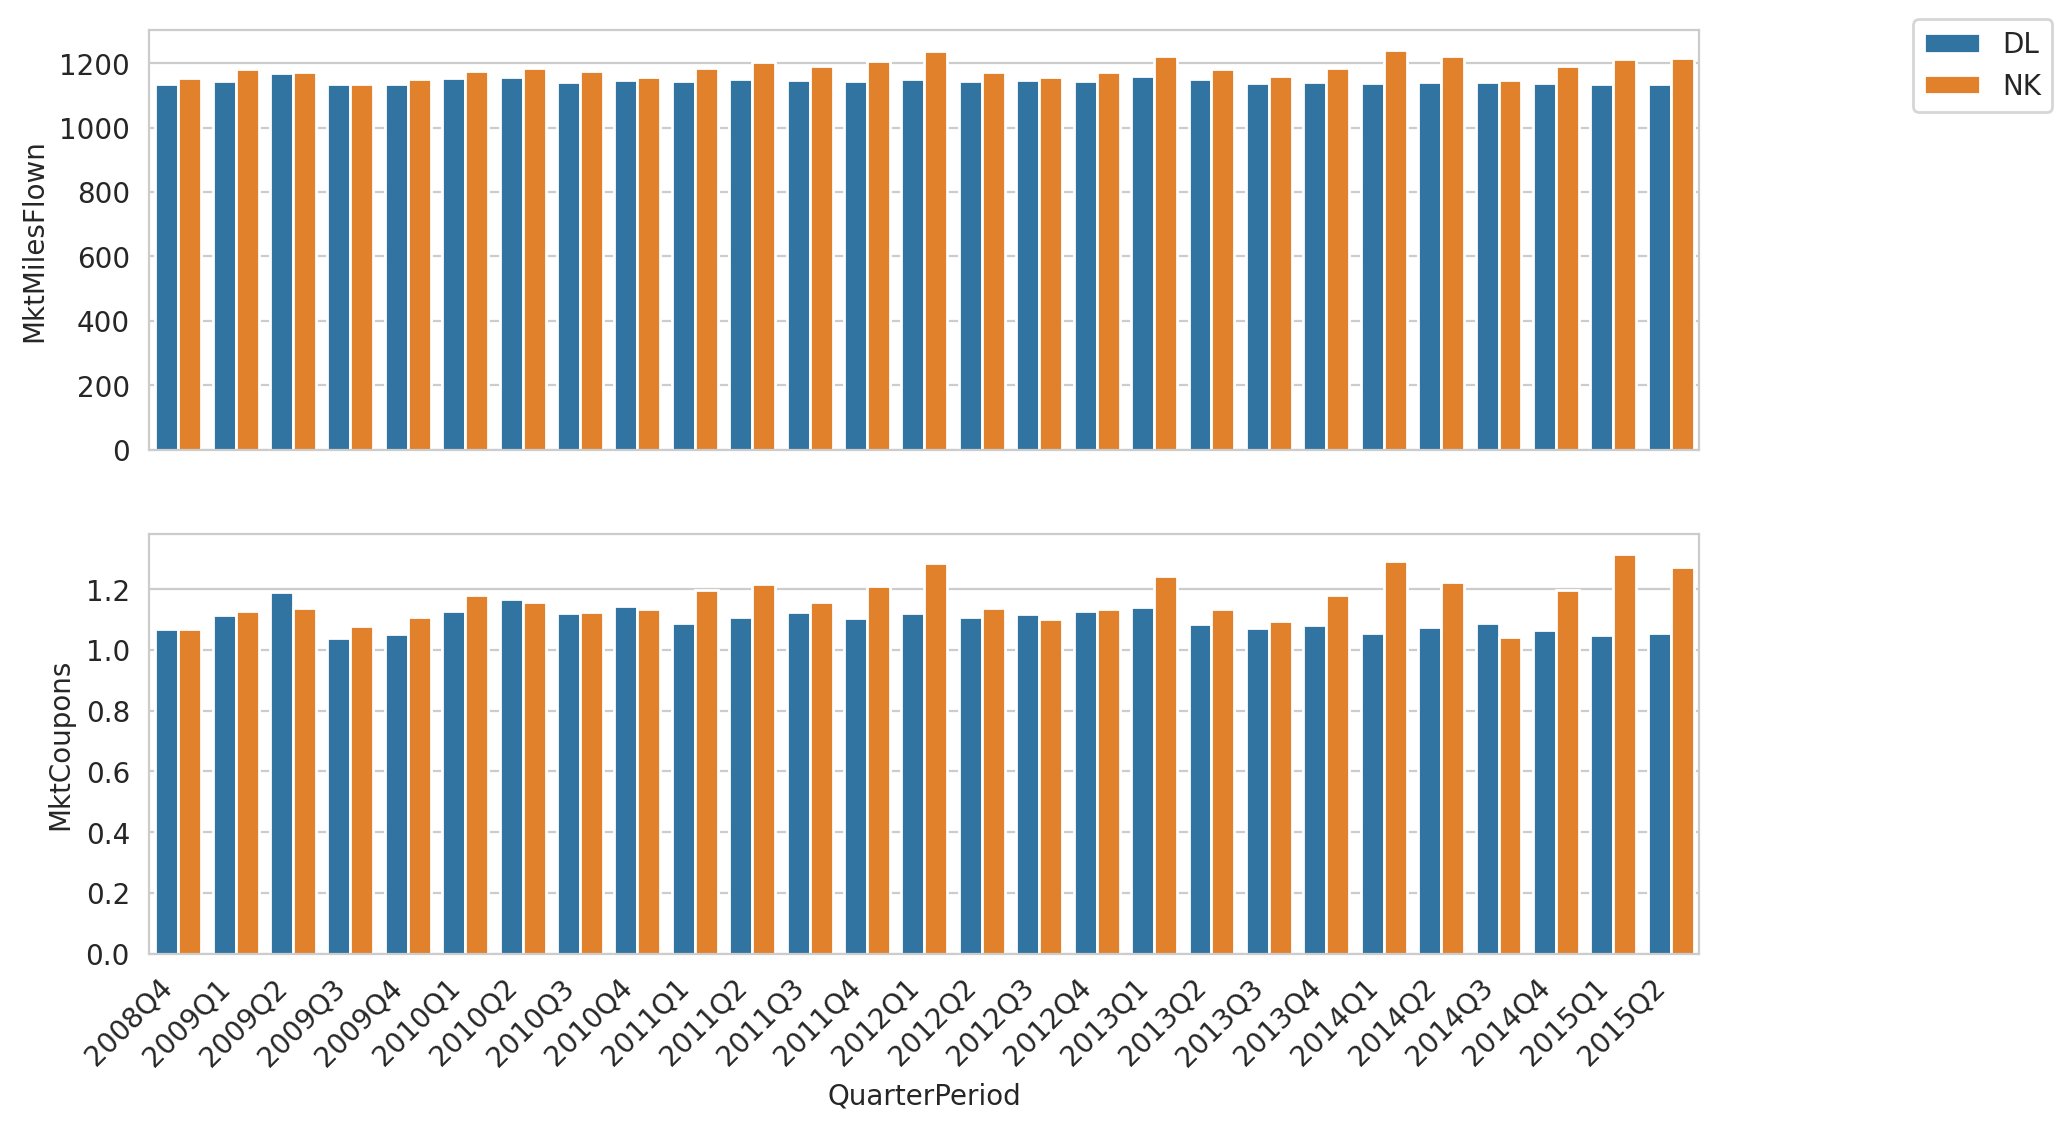

In [9]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), sharex=True)

sns.barplot(
    data=dtw_fll_df,
    x='QuarterPeriod',
    y='MktMilesFlown',
    hue='RPCarrier',
    hue_order=['DL','NK'],
    errorbar=('ci', False),
    ax=ax[0]
)
sns.barplot(
    data=dtw_fll_df,
    x='QuarterPeriod',
    y='MktCoupons',
    hue='RPCarrier',
    hue_order=['DL','NK'],
    errorbar=('ci', False),
    ax=ax[1]
)
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 0.9))
ax[0].get_legend().remove()
ax[1].get_legend().remove()
plt.xticks(rotation=45, ha='right')
plt.show()

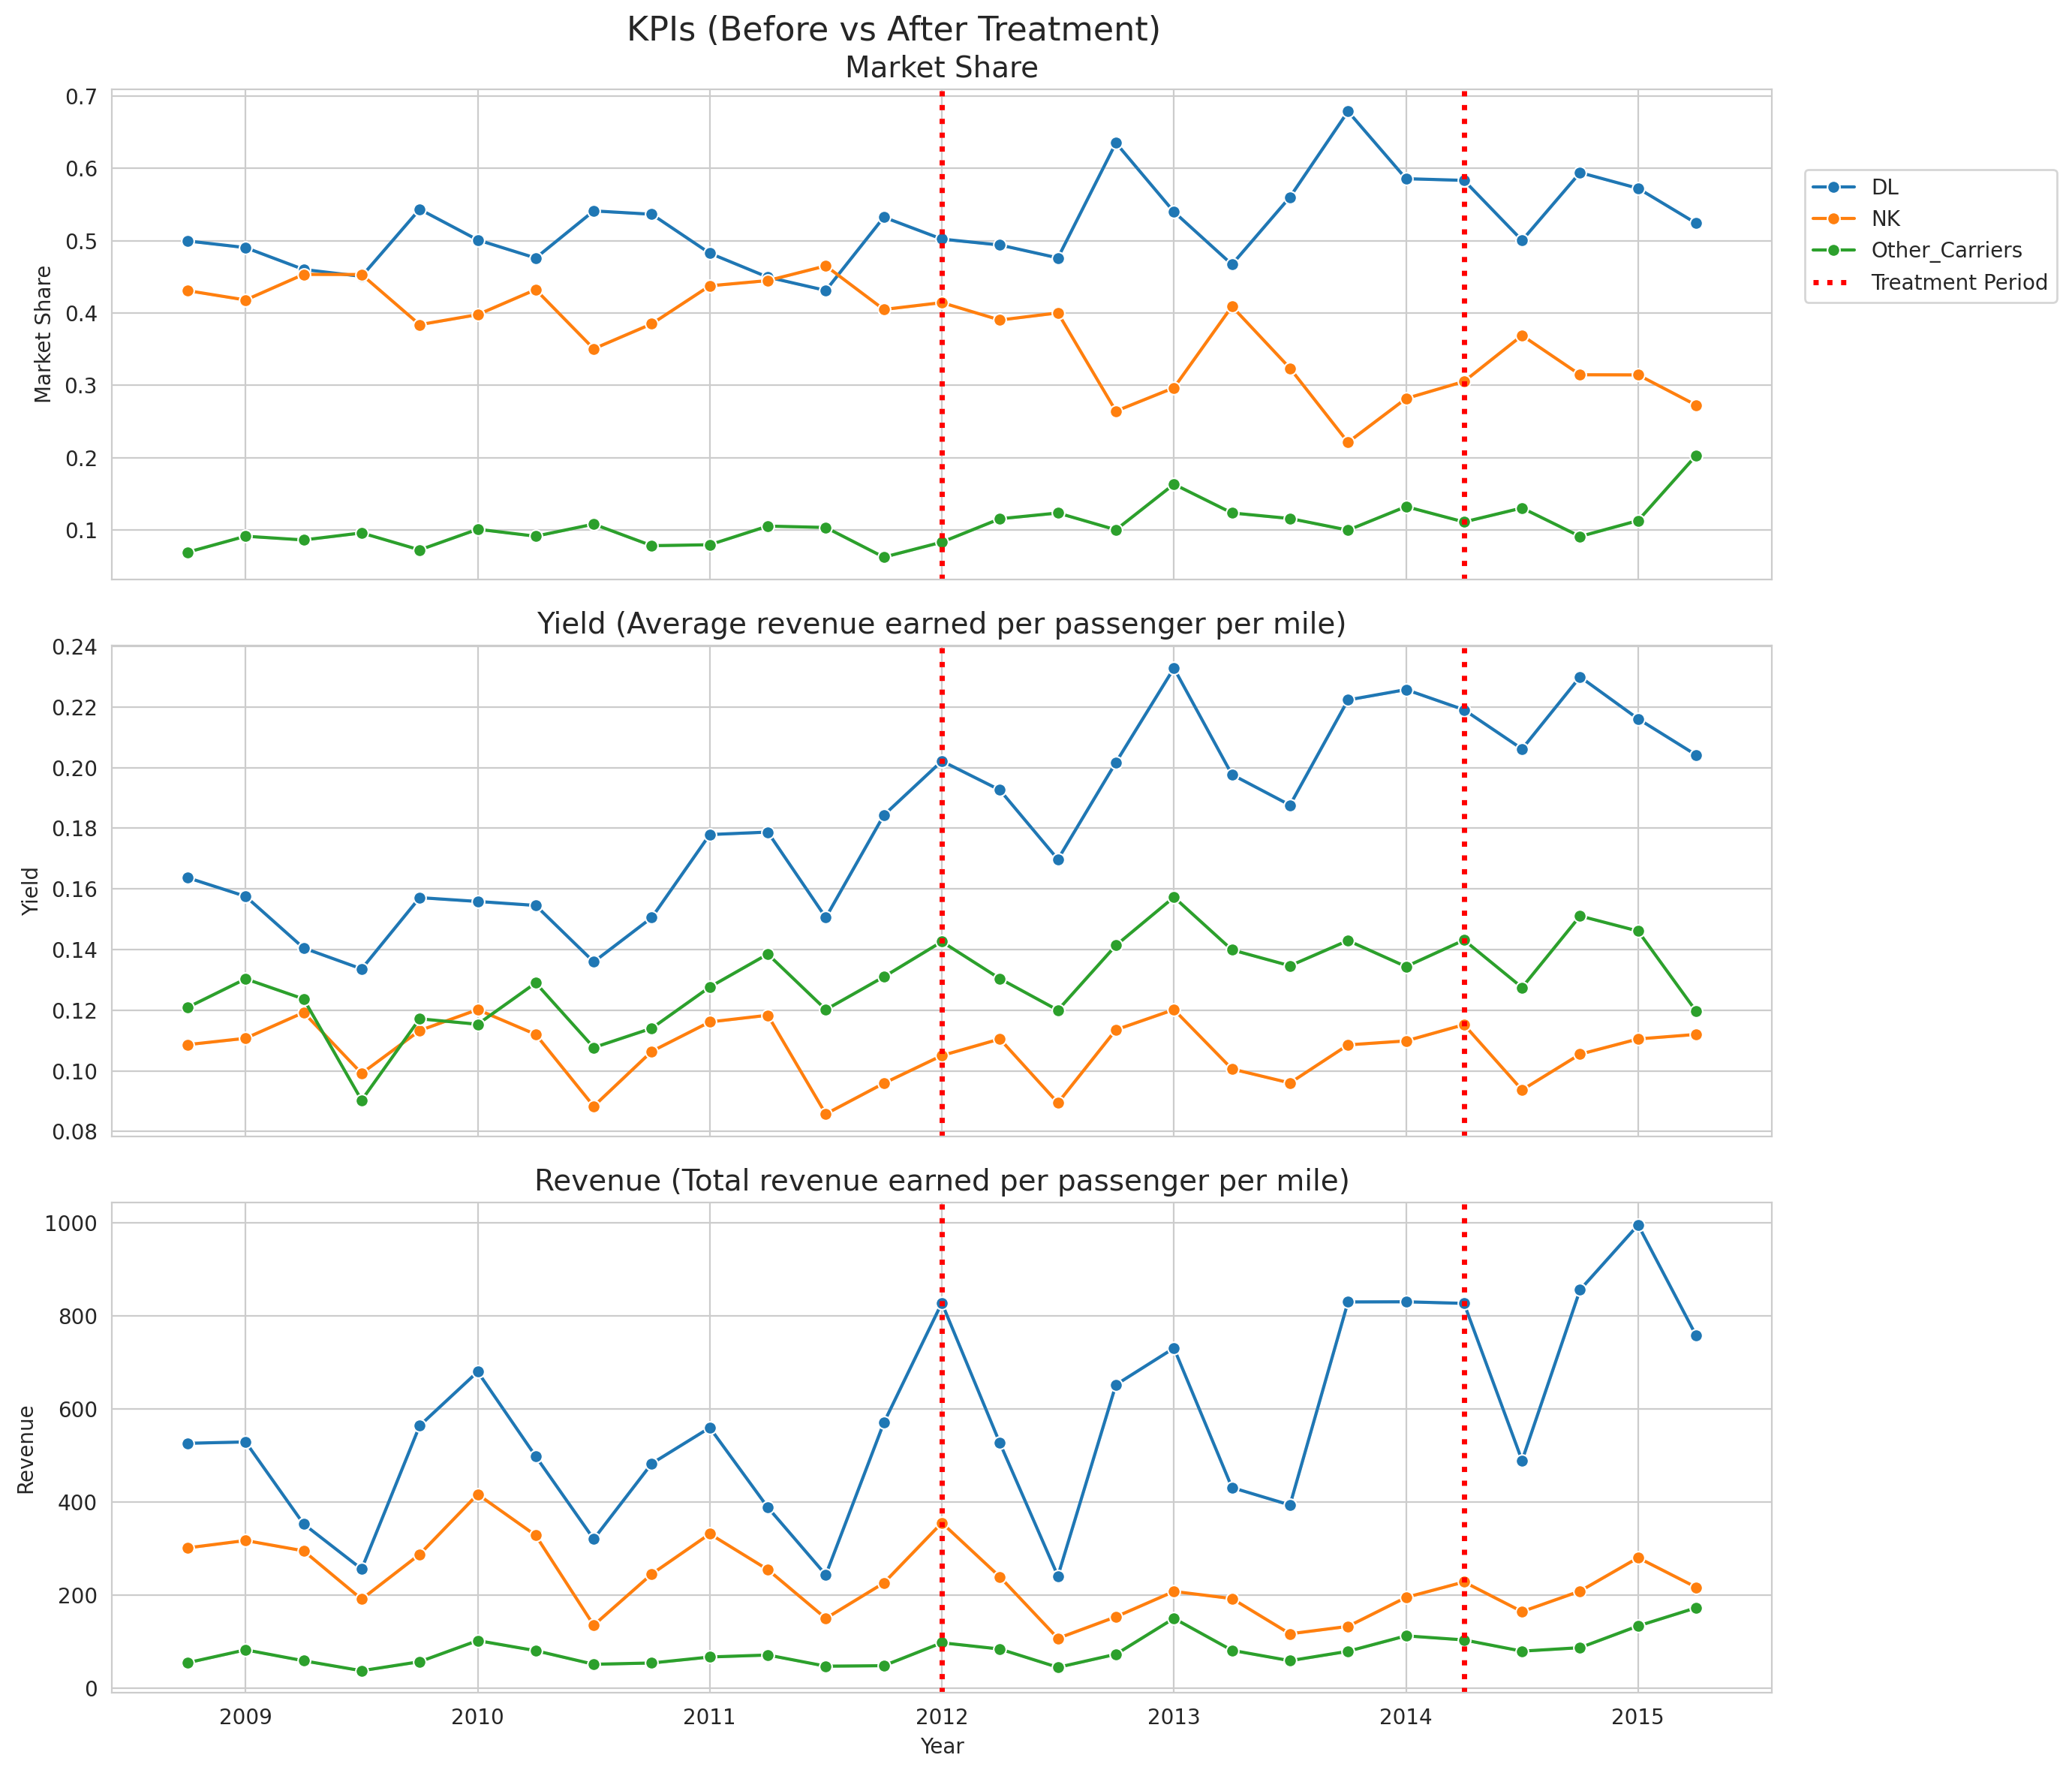

In [10]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 12), sharex=True)

sns.lineplot(
    data=clean_quant_fll_df,
    x='Time_Numeric',
    y='Quarter_Market_Share',
    hue='RPCarrier',
    hue_order=['DL', 'NK', 'Other_Carriers'],
    marker='o',
    ax=ax[0],
)
ax[0].set_title('Market Share', fontsize=14)
ax[0].set_ylabel('Market Share')

sns.lineplot(
    data=clean_quant_fll_df,
    x='Time_Numeric',
    y='Quarter_Yield_mean',
    hue='RPCarrier',
    hue_order=['DL', 'NK', 'Other_Carriers'],
    marker='o',
    legend=False,
    ax=ax[1],
)
ax[1].set_title('Yield (Average revenue earned per passenger per mile)', fontsize=14)
ax[1].set_ylabel('Yield')
ax[1].set_xlabel('Year')

sns.lineplot(
    data=clean_quant_fll_df,
    x='Time_Numeric',
    y='Quarter_Revenue_sum',
    hue='RPCarrier',
    hue_order=['DL', 'NK', 'Other_Carriers'],
    marker='o',
    legend=False,
    ax=ax[2],
)
ax[2].set_title('Revenue (Total revenue earned per passenger per mile)', fontsize=14)
ax[2].set_ylabel('Revenue')
ax[2].set_xlabel('Year')

treatment_start_time = 2012
treatment_end_time = 2014.25
for a in ax:
    a.axvline(x=treatment_start_time, color='red', linestyle=':',
              linewidth=2.5, label='Treatment Period')
    a.axvline(x=treatment_end_time, color='red', linestyle=':',
              linewidth=2.5)

handles, labels = ax[0].get_legend_handles_labels()


fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 0.9))
ax[0].get_legend().remove()
fig.suptitle('KPIs (Before vs After Treatment)', fontsize=16)
plt.tight_layout()
save_path = os.path.join(plots_folder, 'KPIs_Before_After.png')
plt.savefig(save_path)

plt.show()

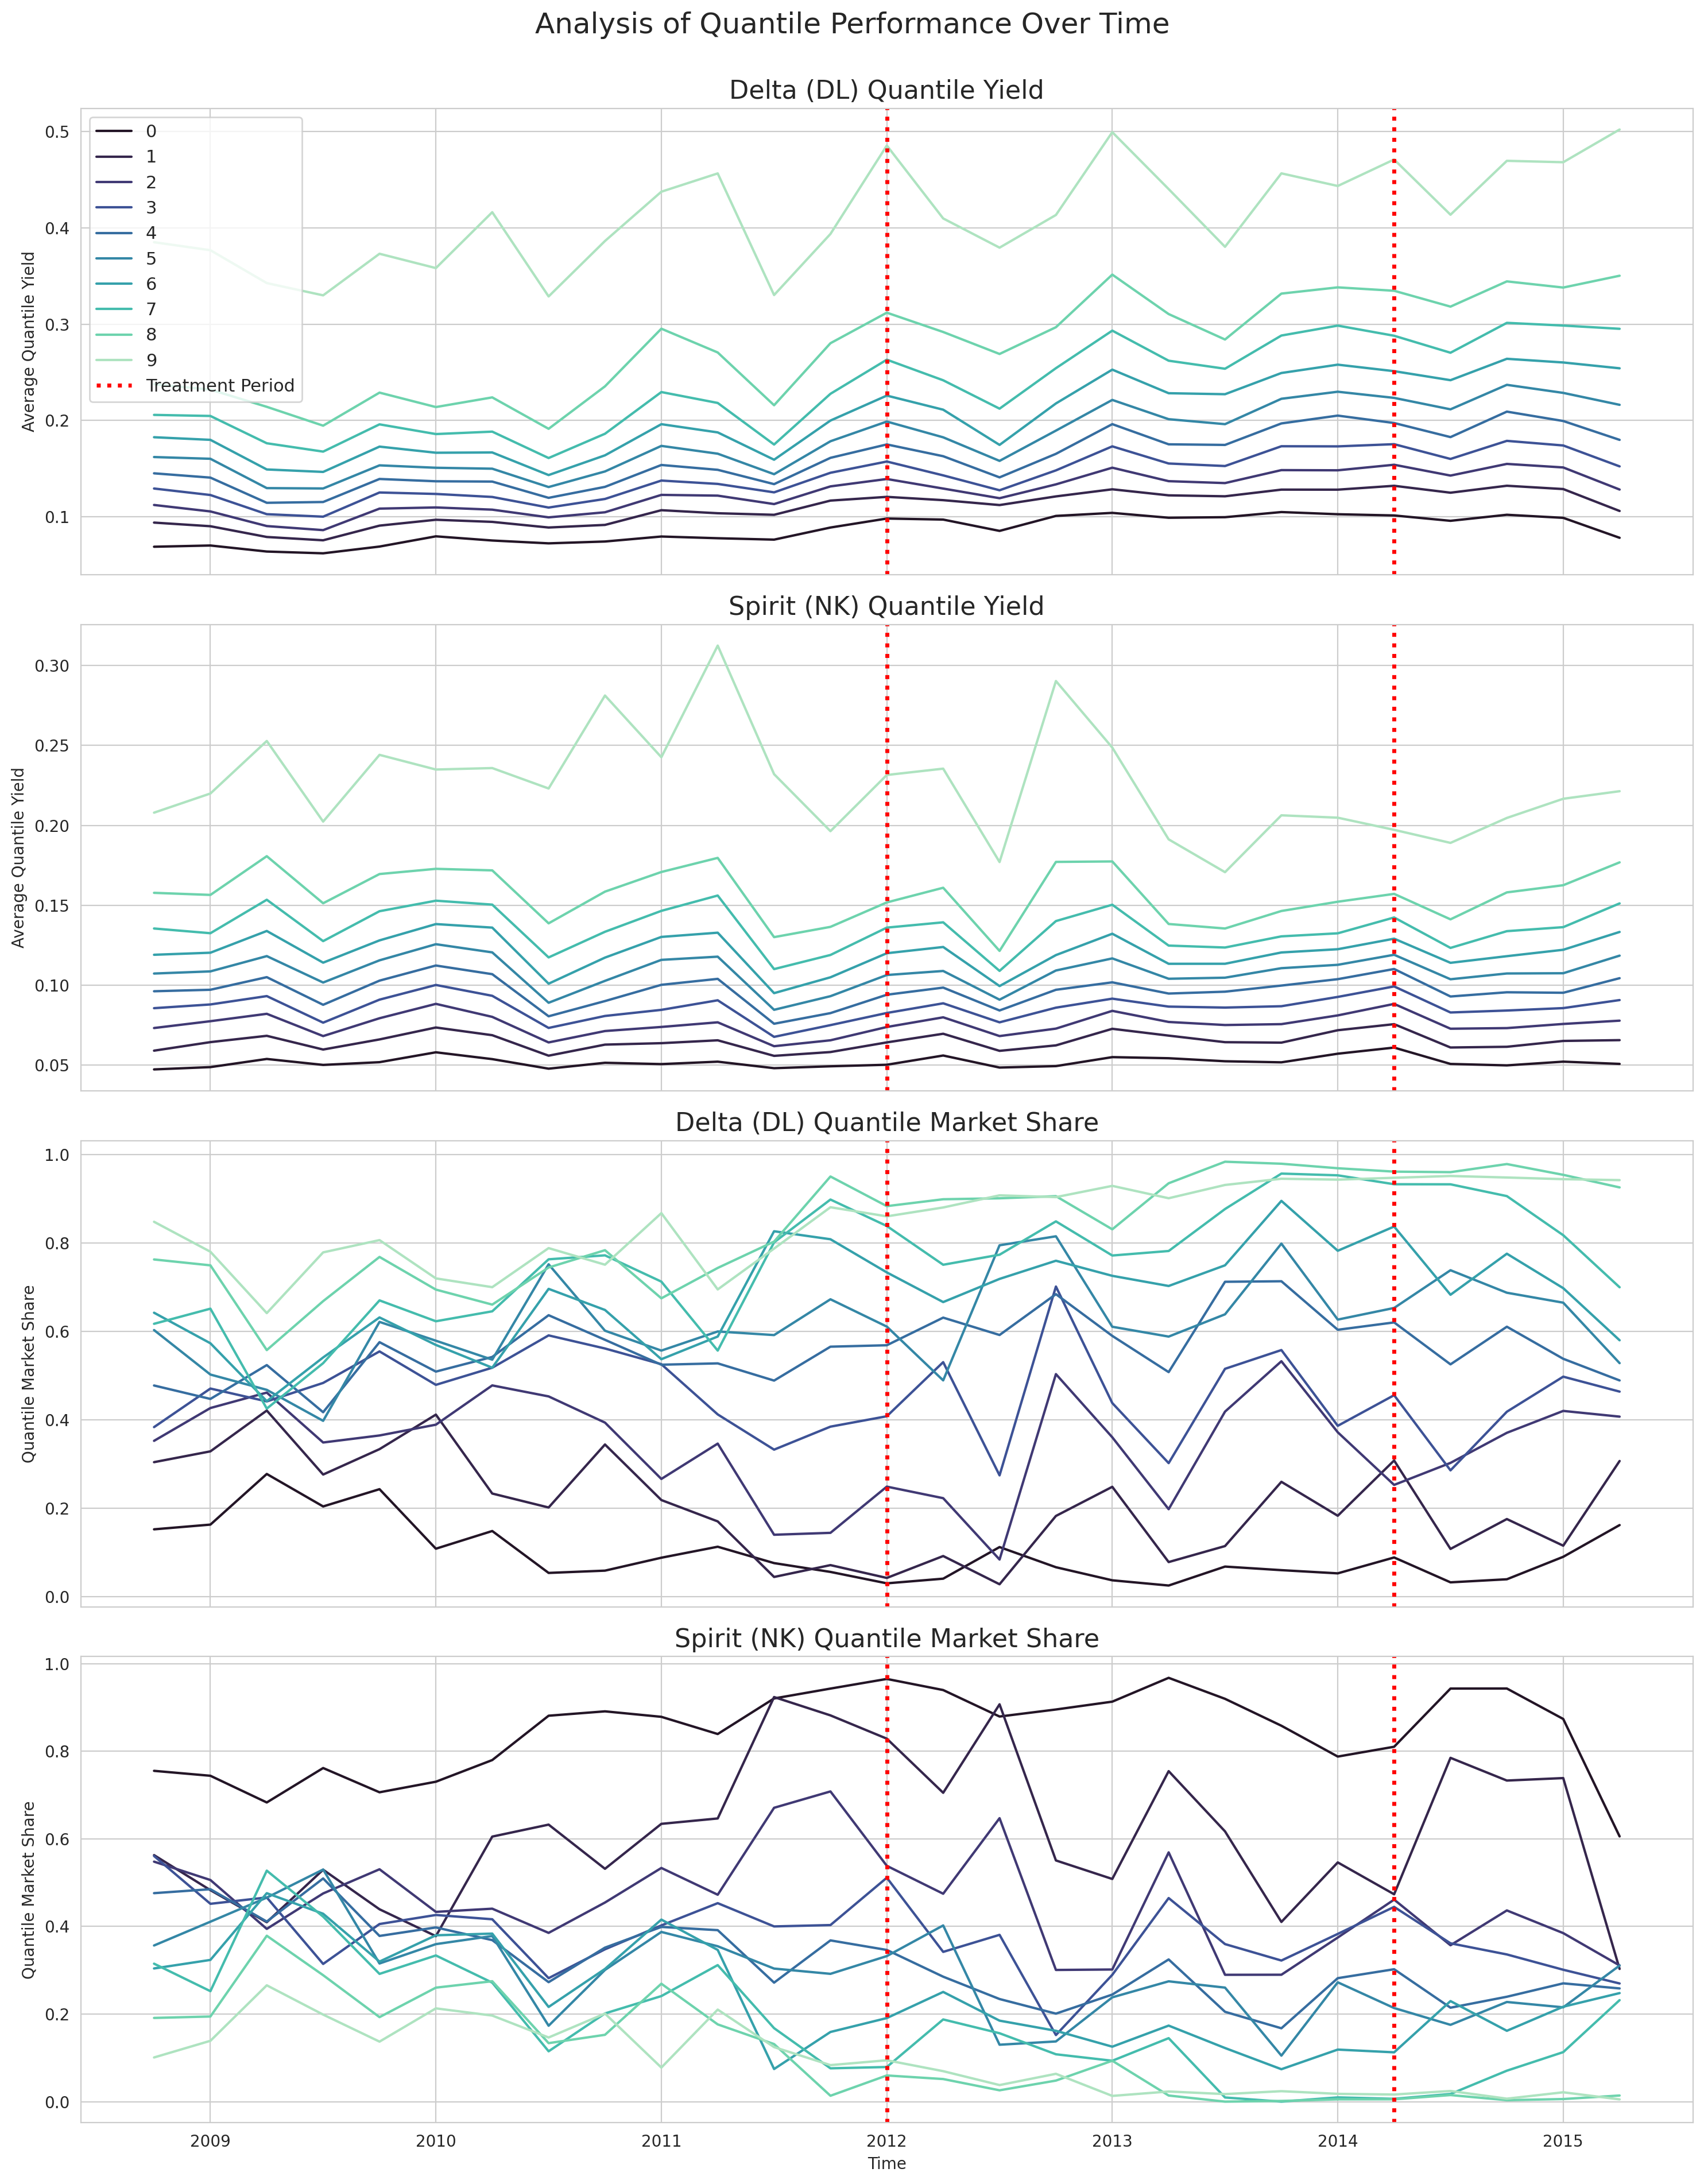

In [11]:
sns.set_style("whitegrid")

n_quantiles = agg_quantile_fll_df['Quantile_id'].nunique()
sequential_palette = sns.color_palette("mako", n_colors=n_quantiles)

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 20), sharex=True)
sns.set_theme(style="whitegrid")

sns.lineplot(
    data=dl_data,
    x='Time_Numeric',
    y='Carrier_Quantile_Yield',
    hue='Quantile_id',
    palette=sequential_palette,
    ax=ax[0]
)
ax[0].set_title('Delta (DL) Quantile Yield', fontsize=16)
ax[0].set_ylabel('Average Quantile Yield')


sns.lineplot(
    data=nk_data,
    x='Time_Numeric',
    y='Carrier_Quantile_Yield',
    hue='Quantile_id',
    palette=sequential_palette,
    legend=False,
    ax=ax[1]
)
ax[1].set_title('Spirit (NK) Quantile Yield', fontsize=16)
ax[1].set_ylabel('Average Quantile Yield')


sns.lineplot(
    data=dl_data,
    x='Time_Numeric',
    y='Market_Quantile_Share',
    hue='Quantile_id',
    palette=sequential_palette,
    legend=False,
    ax=ax[2]
)
ax[2].set_title('Delta (DL) Quantile Market Share', fontsize=16)
ax[2].set_ylabel('Quantile Market Share')



sns.lineplot(
    data=nk_data,
    x='Time_Numeric',
    y='Market_Quantile_Share',
    hue='Quantile_id',
    palette=sequential_palette,
    legend=False,
    ax=ax[3]
)
ax[3].set_title('Spirit (NK) Quantile Market Share', fontsize=16)
ax[3].set_ylabel('Quantile Market Share')
ax[3].set_xlabel('Time')
for a in ax:
    a.axvline(x=treatment_start_time, color='red', linestyle=':',
              linewidth=2.5, label='Treatment Period')
    a.axvline(x=treatment_end_time, color='red', linestyle=':',
              linewidth=2.5)

ax[0].legend(loc='upper left')
fig.suptitle('Analysis of Quantile Performance Over Time', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

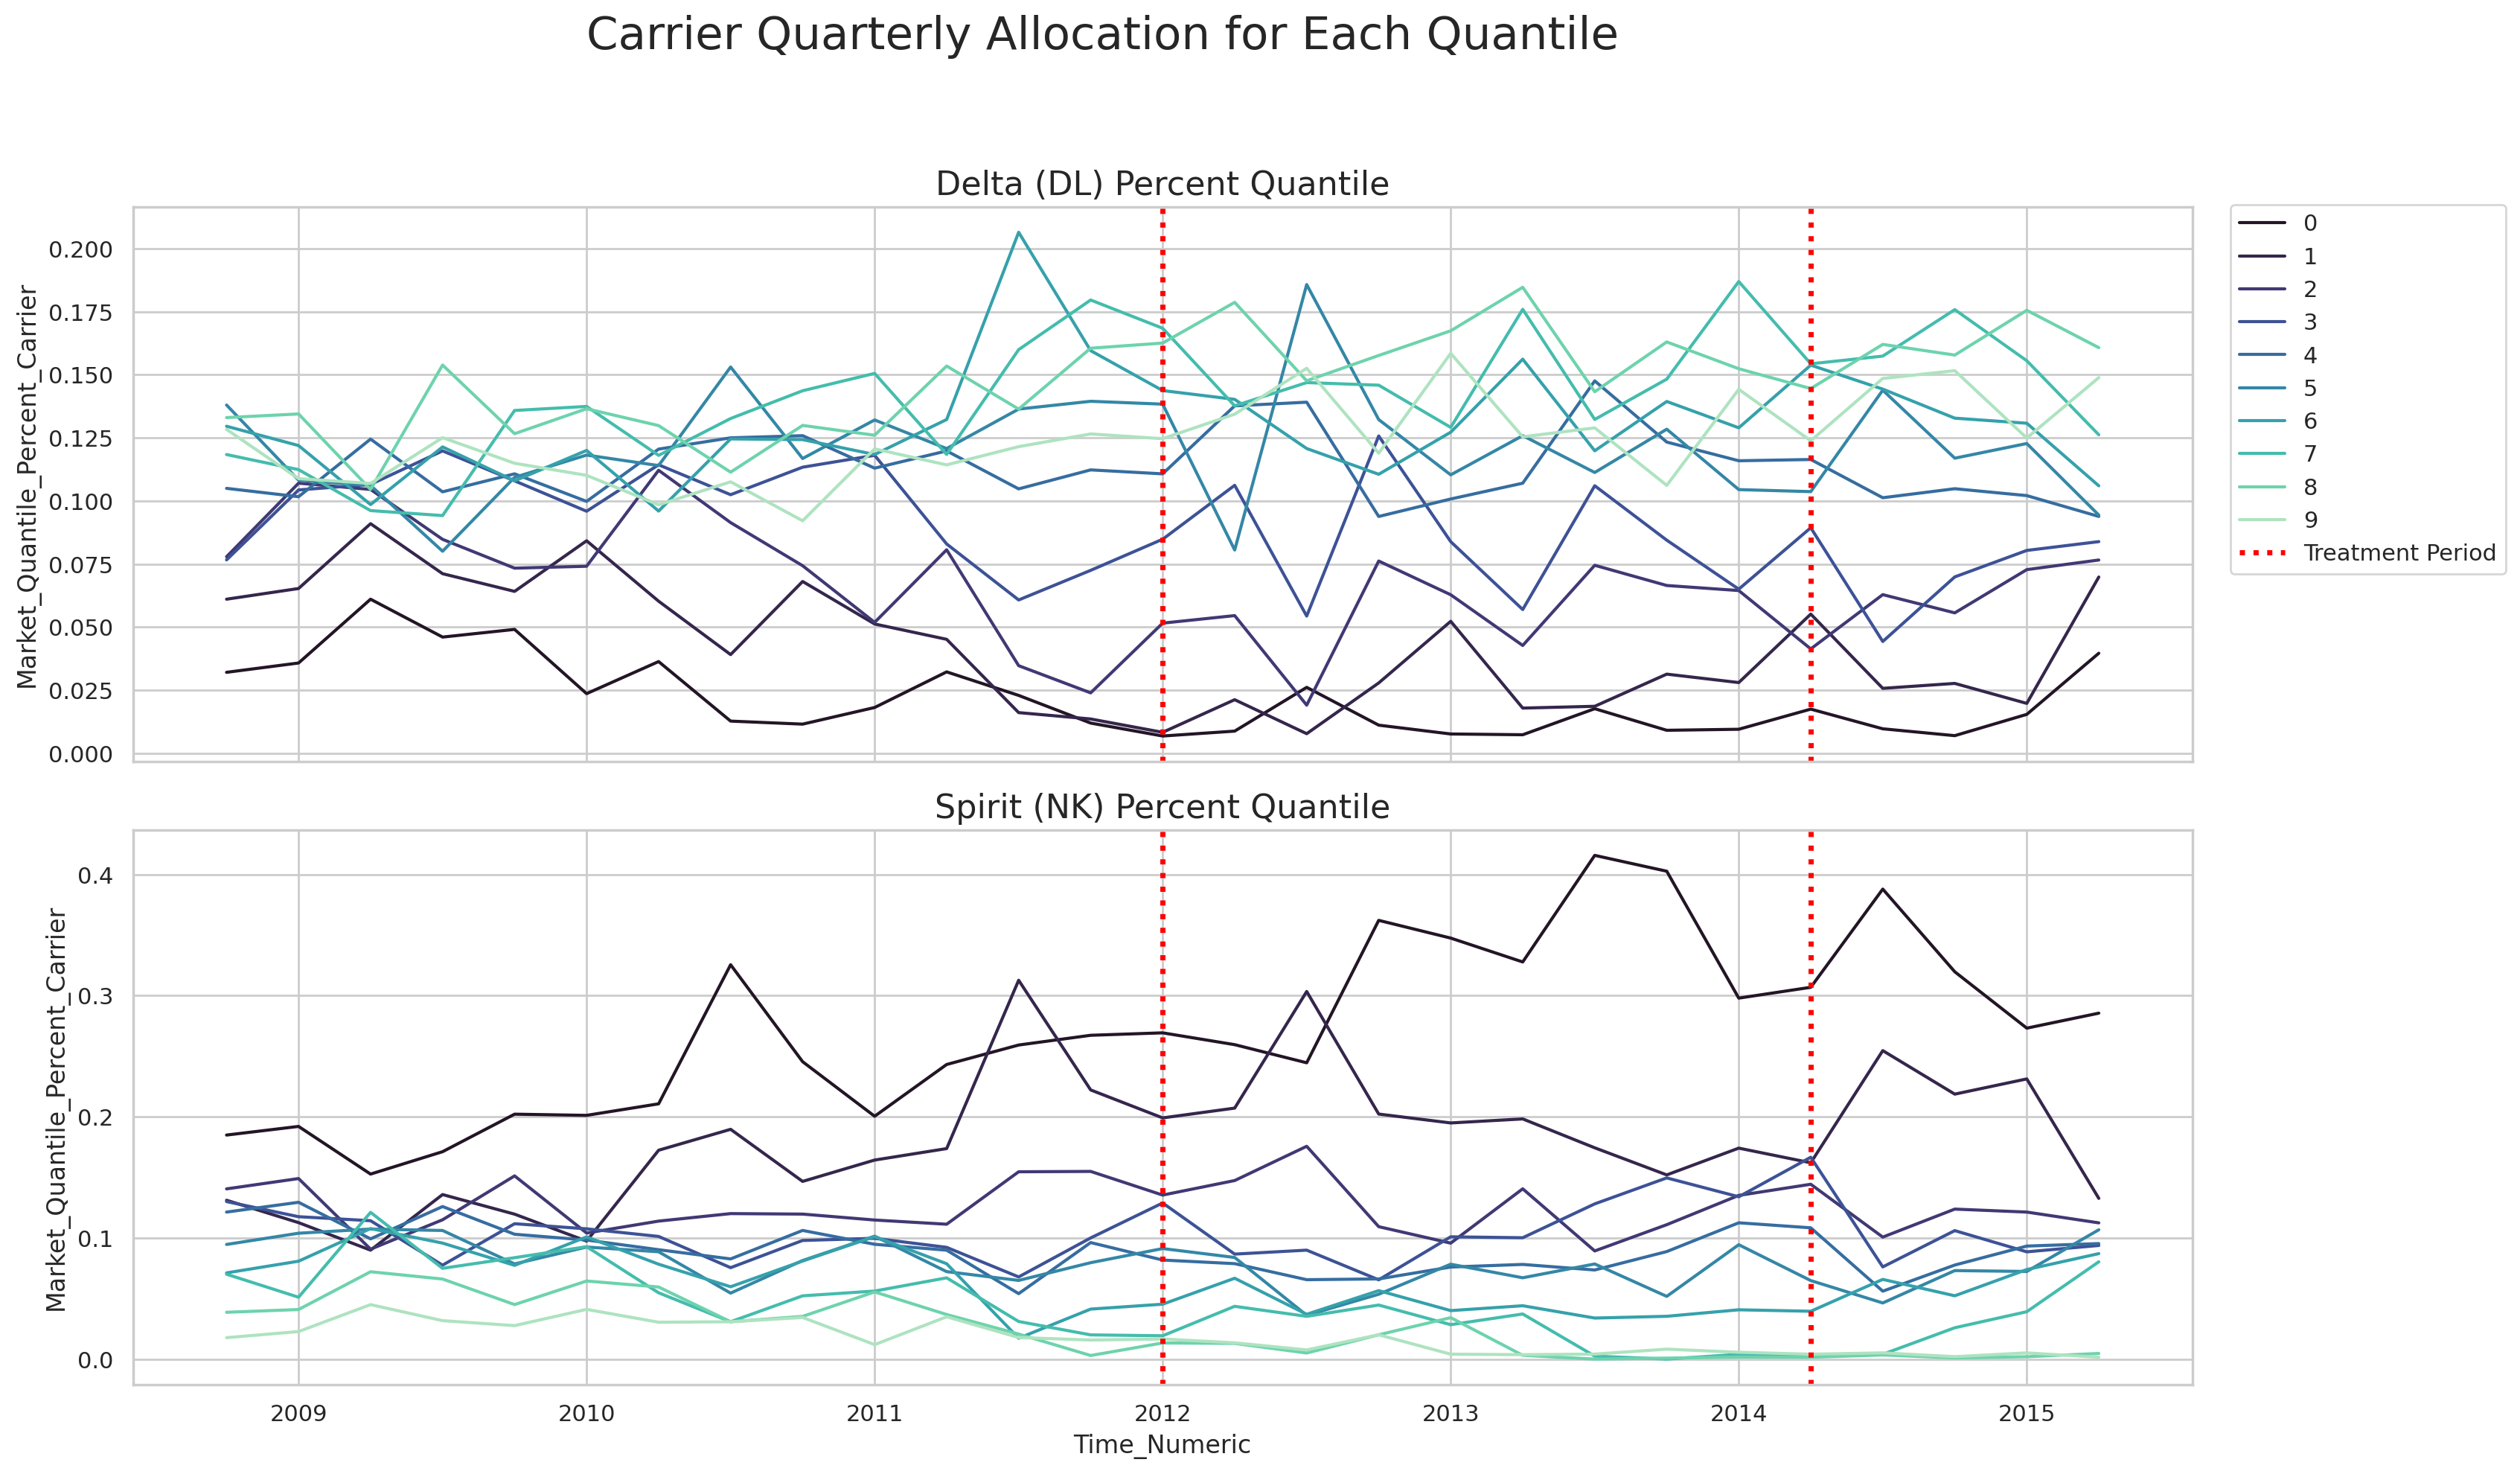

In [12]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 10), sharex=True)

sns.lineplot(
    data=dl_data,
    x='Time_Numeric',
    y='Market_Quantile_Percent_Carrier',
    hue='Quantile_id',
    palette=sequential_palette,
    ax=ax[0]
)
ax[0].set_title('Delta (DL) Percent Quantile', fontsize=16)
ax[0].legend(title='Quantile ID')


sns.lineplot(
    data=nk_data,
    x='Time_Numeric',
    y='Market_Quantile_Percent_Carrier',
    hue='Quantile_id',
    palette=sequential_palette,
    ax=ax[1]
)
ax[1].set_title('Spirit (NK) Percent Quantile', fontsize=16)
ax[1].legend(title='Quantile ID')


for a in ax:
    a.axvline(x=treatment_start_time, color='red', linestyle=':',
              linewidth=2.5, label='Treatment Period')
    a.axvline(x=treatment_end_time, color='red', linestyle=':',
              linewidth=2.5)

handles, labels = ax[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 0.9))
ax[0].get_legend().remove()
ax[1].get_legend().remove()

fig.suptitle('Carrier Quarterly Allocation for Each Quantile', fontsize=22, y=1.02)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

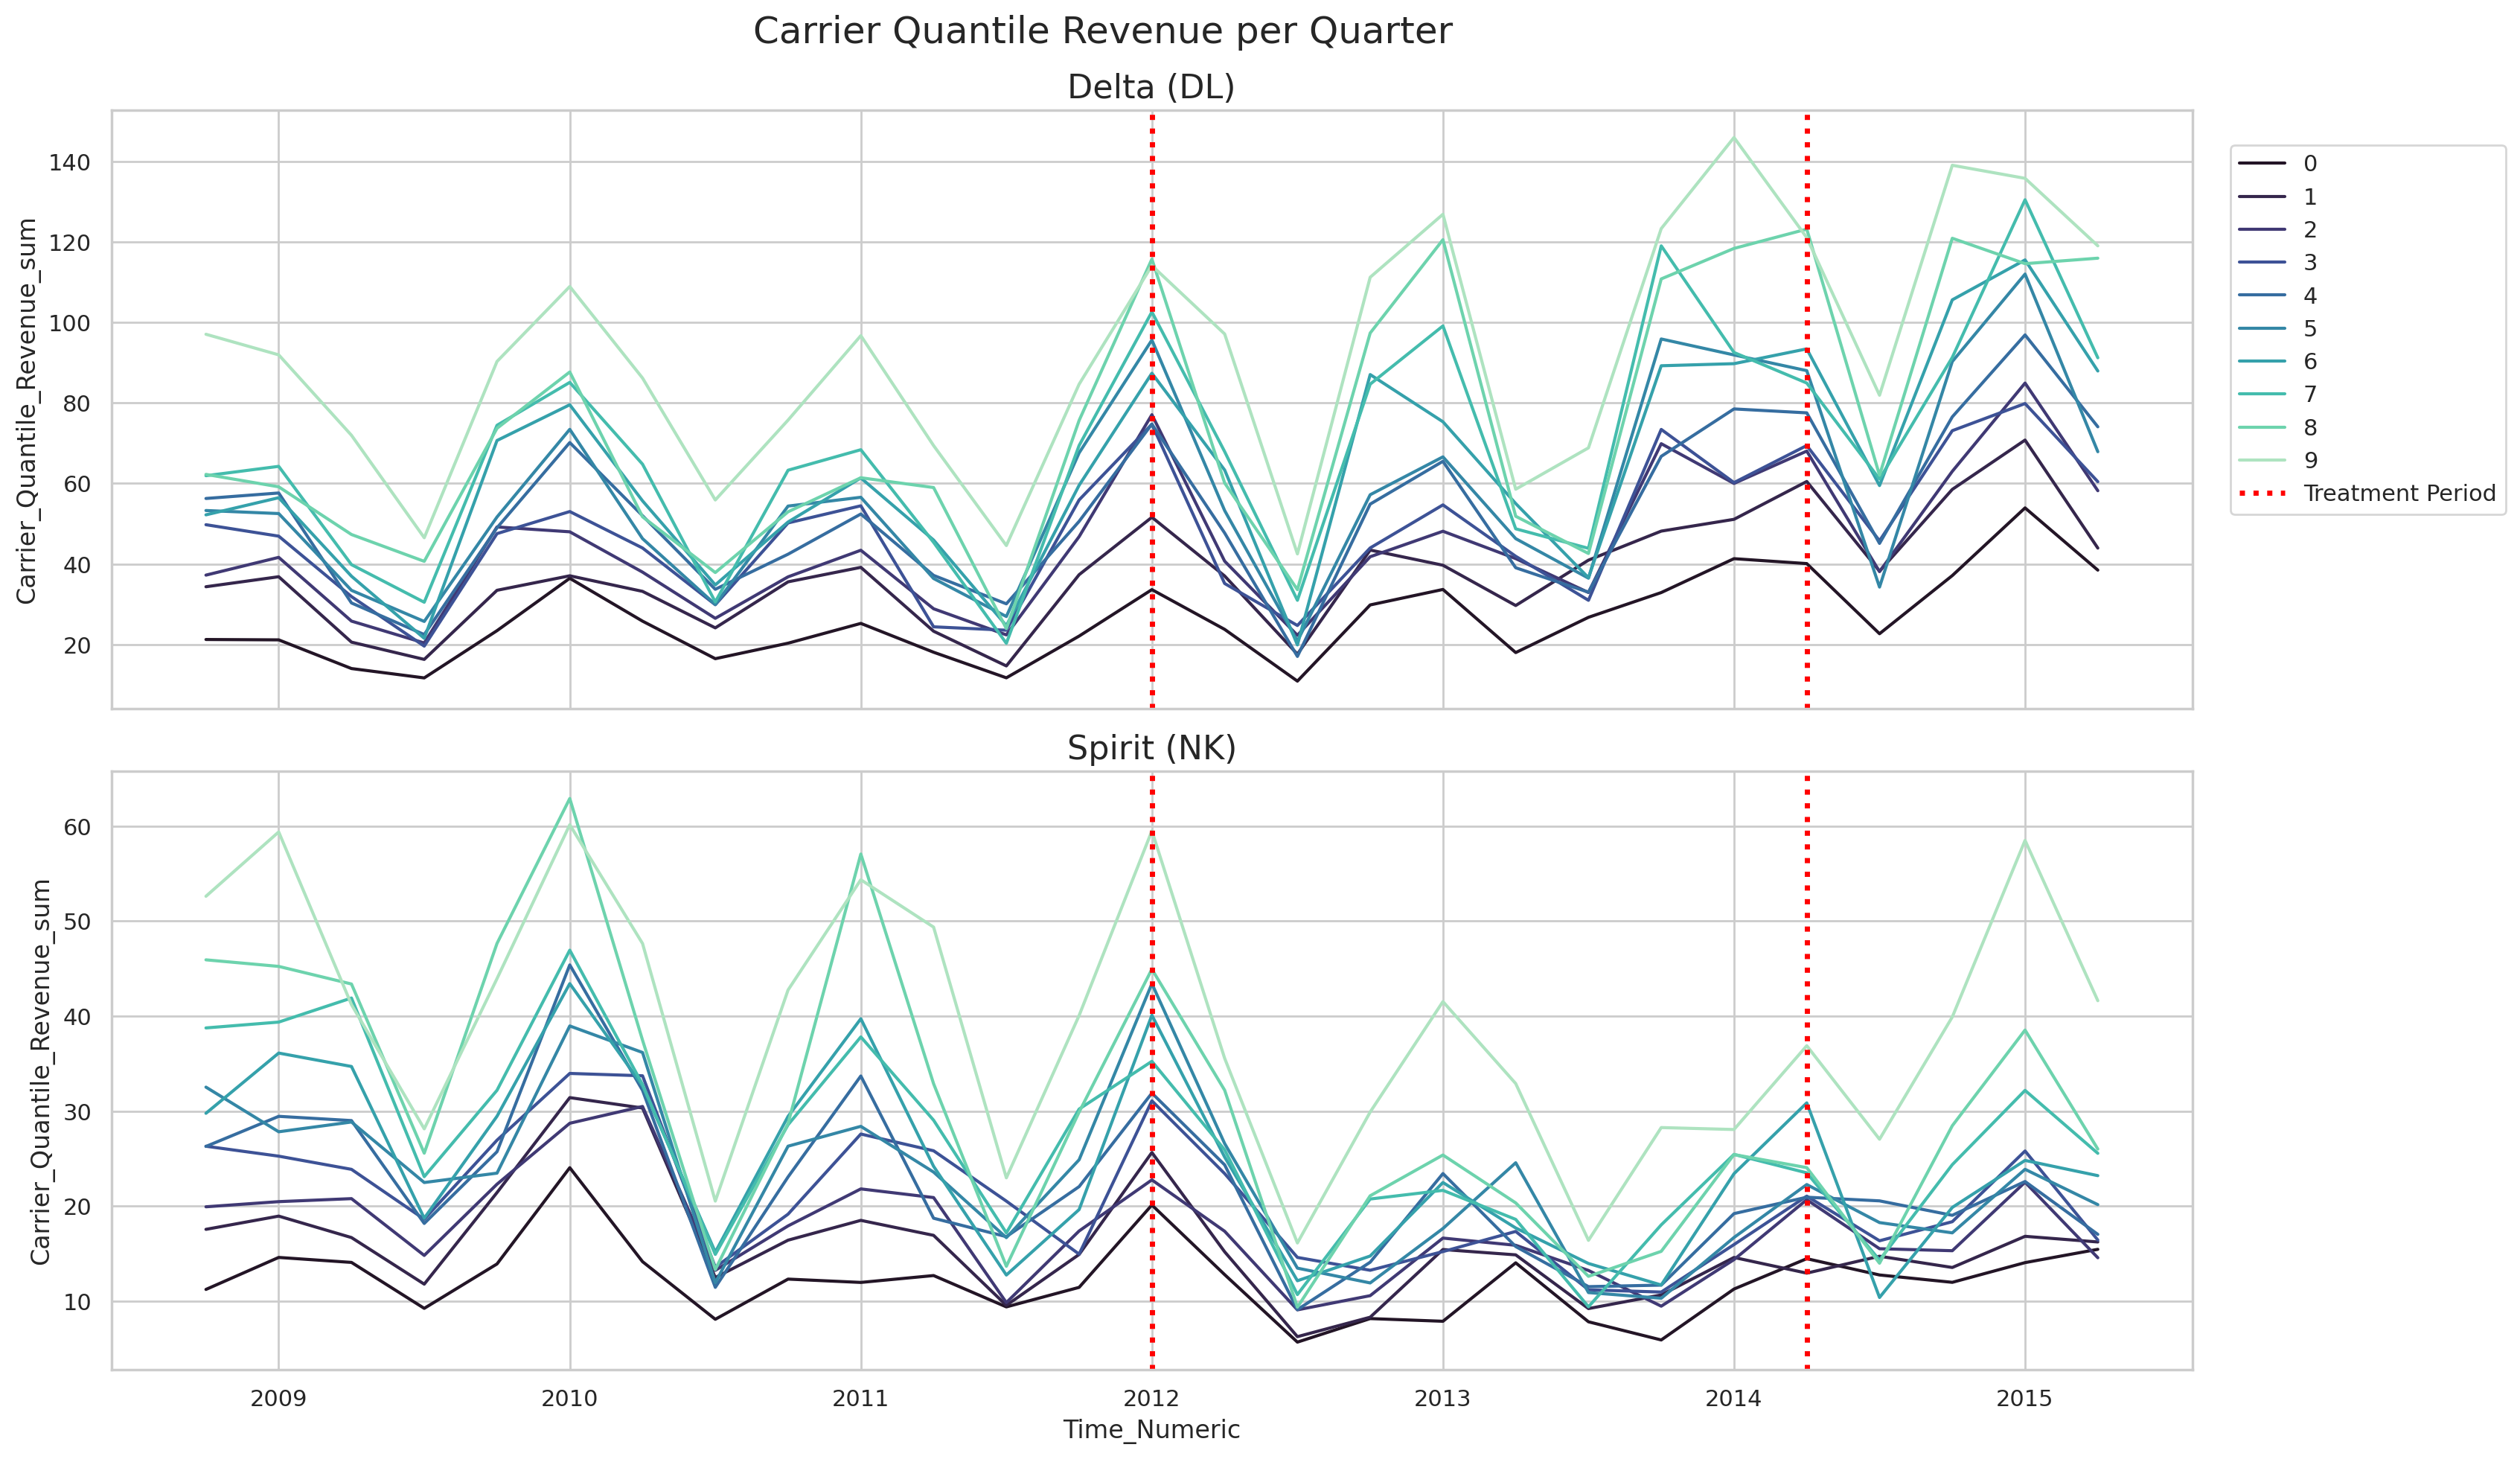

In [13]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 10), sharex=True)

sns.lineplot(
    data=dl_data,
    x='Time_Numeric',
    y='Carrier_Quantile_Revenue_sum',
    hue='Quantile_id',
    palette=sequential_palette,
    ax=ax[0]
)
ax[0].set_title('Delta (DL)', fontsize=16)
ax[0].legend(title='Quantile ID')


sns.lineplot(
    data=nk_data,
    x='Time_Numeric',
    y='Carrier_Quantile_Revenue_sum',
    hue='Quantile_id',
    palette=sequential_palette,
    ax=ax[1]
)
ax[1].set_title('Spirit (NK)', fontsize=16)
ax[1].legend(title='Quantile ID')

for a in ax:
    a.axvline(x=treatment_start_time, color='red', linestyle=':',
              linewidth=2.5, label='Treatment Period')
    a.axvline(x=treatment_end_time, color='red', linestyle=':',
              linewidth=2.5)


handles, labels = ax[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 0.9))

ax[0].get_legend().remove()
ax[1].get_legend().remove()
fig.suptitle('Carrier Quantile Revenue per Quarter', fontsize=18)
plt.tight_layout()
save_path = os.path.join(plots_folder, 'Carrier_Quantile_Revenue.png')
plt.savefig(save_path)

plt.show()

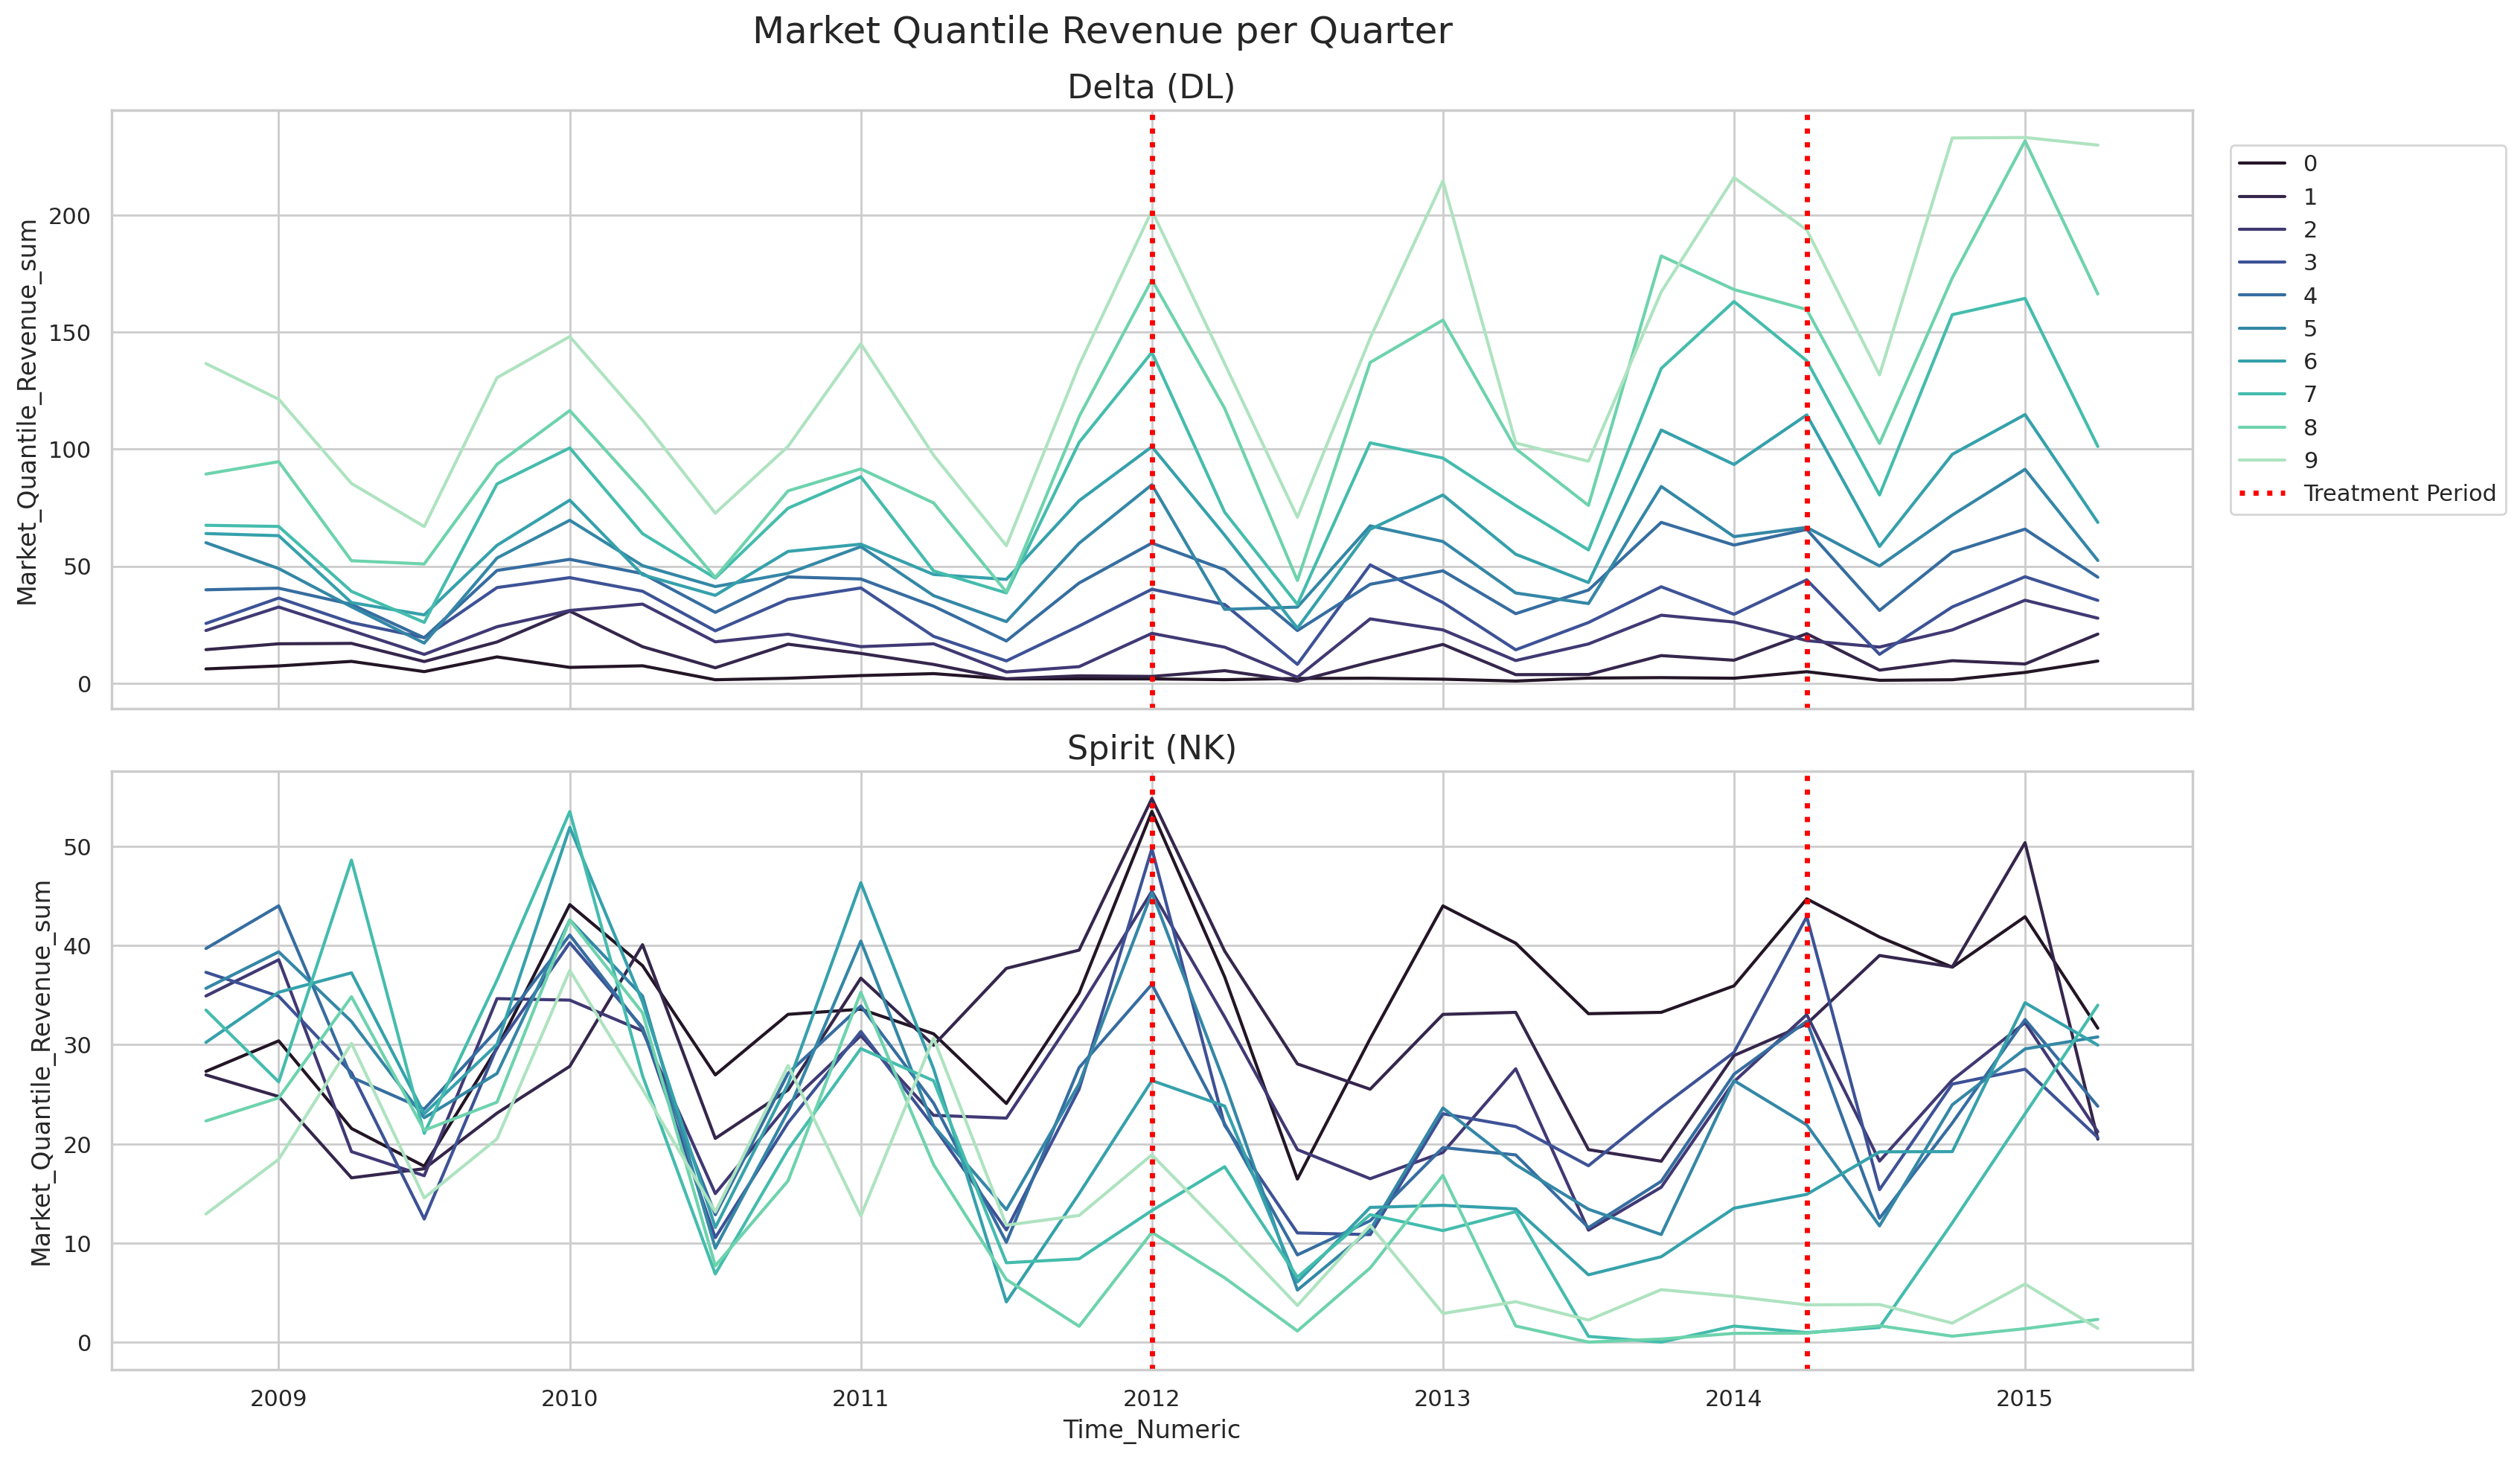

In [14]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 10), sharex=True)

sns.lineplot(
    data=dl_data,
    x='Time_Numeric',
    y='Market_Quantile_Revenue_sum',
    hue='Quantile_id',
    palette=sequential_palette,
    ax=ax[0]
)
ax[0].set_title('Delta (DL)', fontsize=16)
ax[0].legend(title='Quantile ID')


sns.lineplot(
    data=nk_data,
    x='Time_Numeric',
    y='Market_Quantile_Revenue_sum',
    hue='Quantile_id',
    palette=sequential_palette,
    ax=ax[1]
)
ax[1].set_title('Spirit (NK)', fontsize=16)
ax[1].legend(title='Quantile ID')

for a in ax:
    a.axvline(x=treatment_start_time, color='red', linestyle=':',
              linewidth=2.5, label='Treatment Period')
    a.axvline(x=treatment_end_time, color='red', linestyle=':',
              linewidth=2.5)

handles, labels = ax[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 0.9))

ax[0].get_legend().remove()
ax[1].get_legend().remove()
fig.suptitle('Market Quantile Revenue per Quarter', fontsize=18)
plt.tight_layout()
save_path = os.path.join(plots_folder, 'Market_Quantile_Revenue.png')
plt.savefig(save_path)

plt.show()

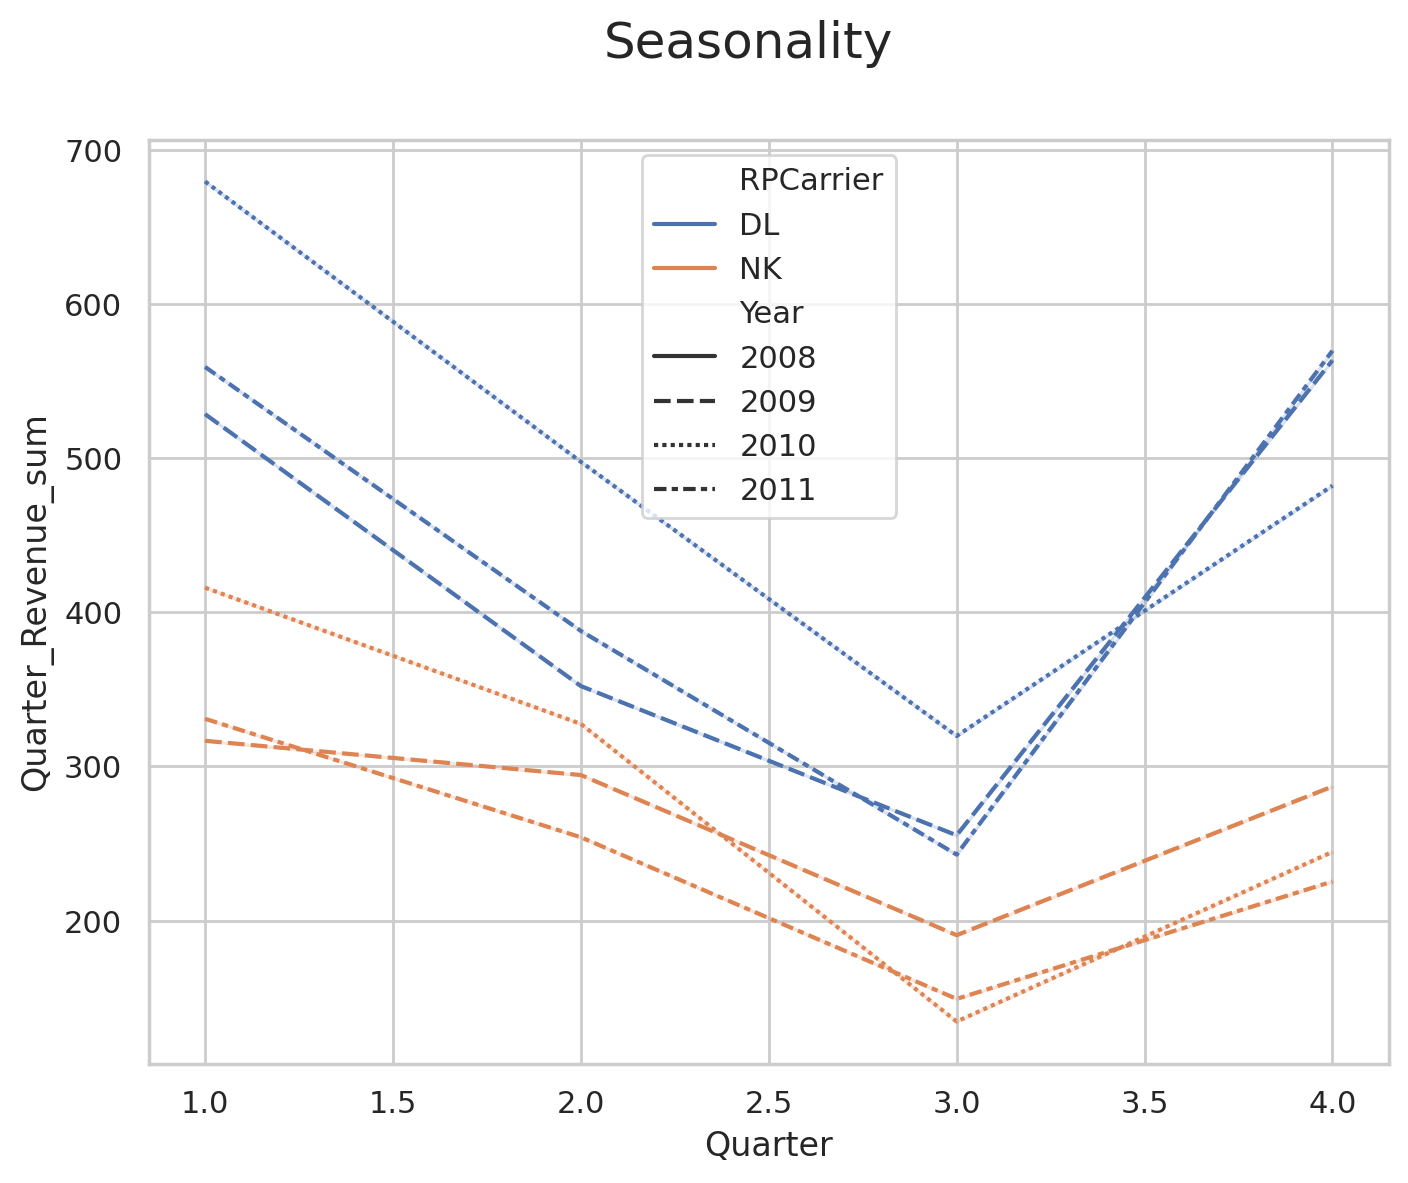

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.lineplot(
    data=pre_fll_df,
    x='Quarter',
    y='Quarter_Revenue_sum',
    style='Year',
    hue='RPCarrier',
    hue_order=['DL', 'NK'],
)

fig.suptitle('Seasonality', fontsize=18)
plt.show()

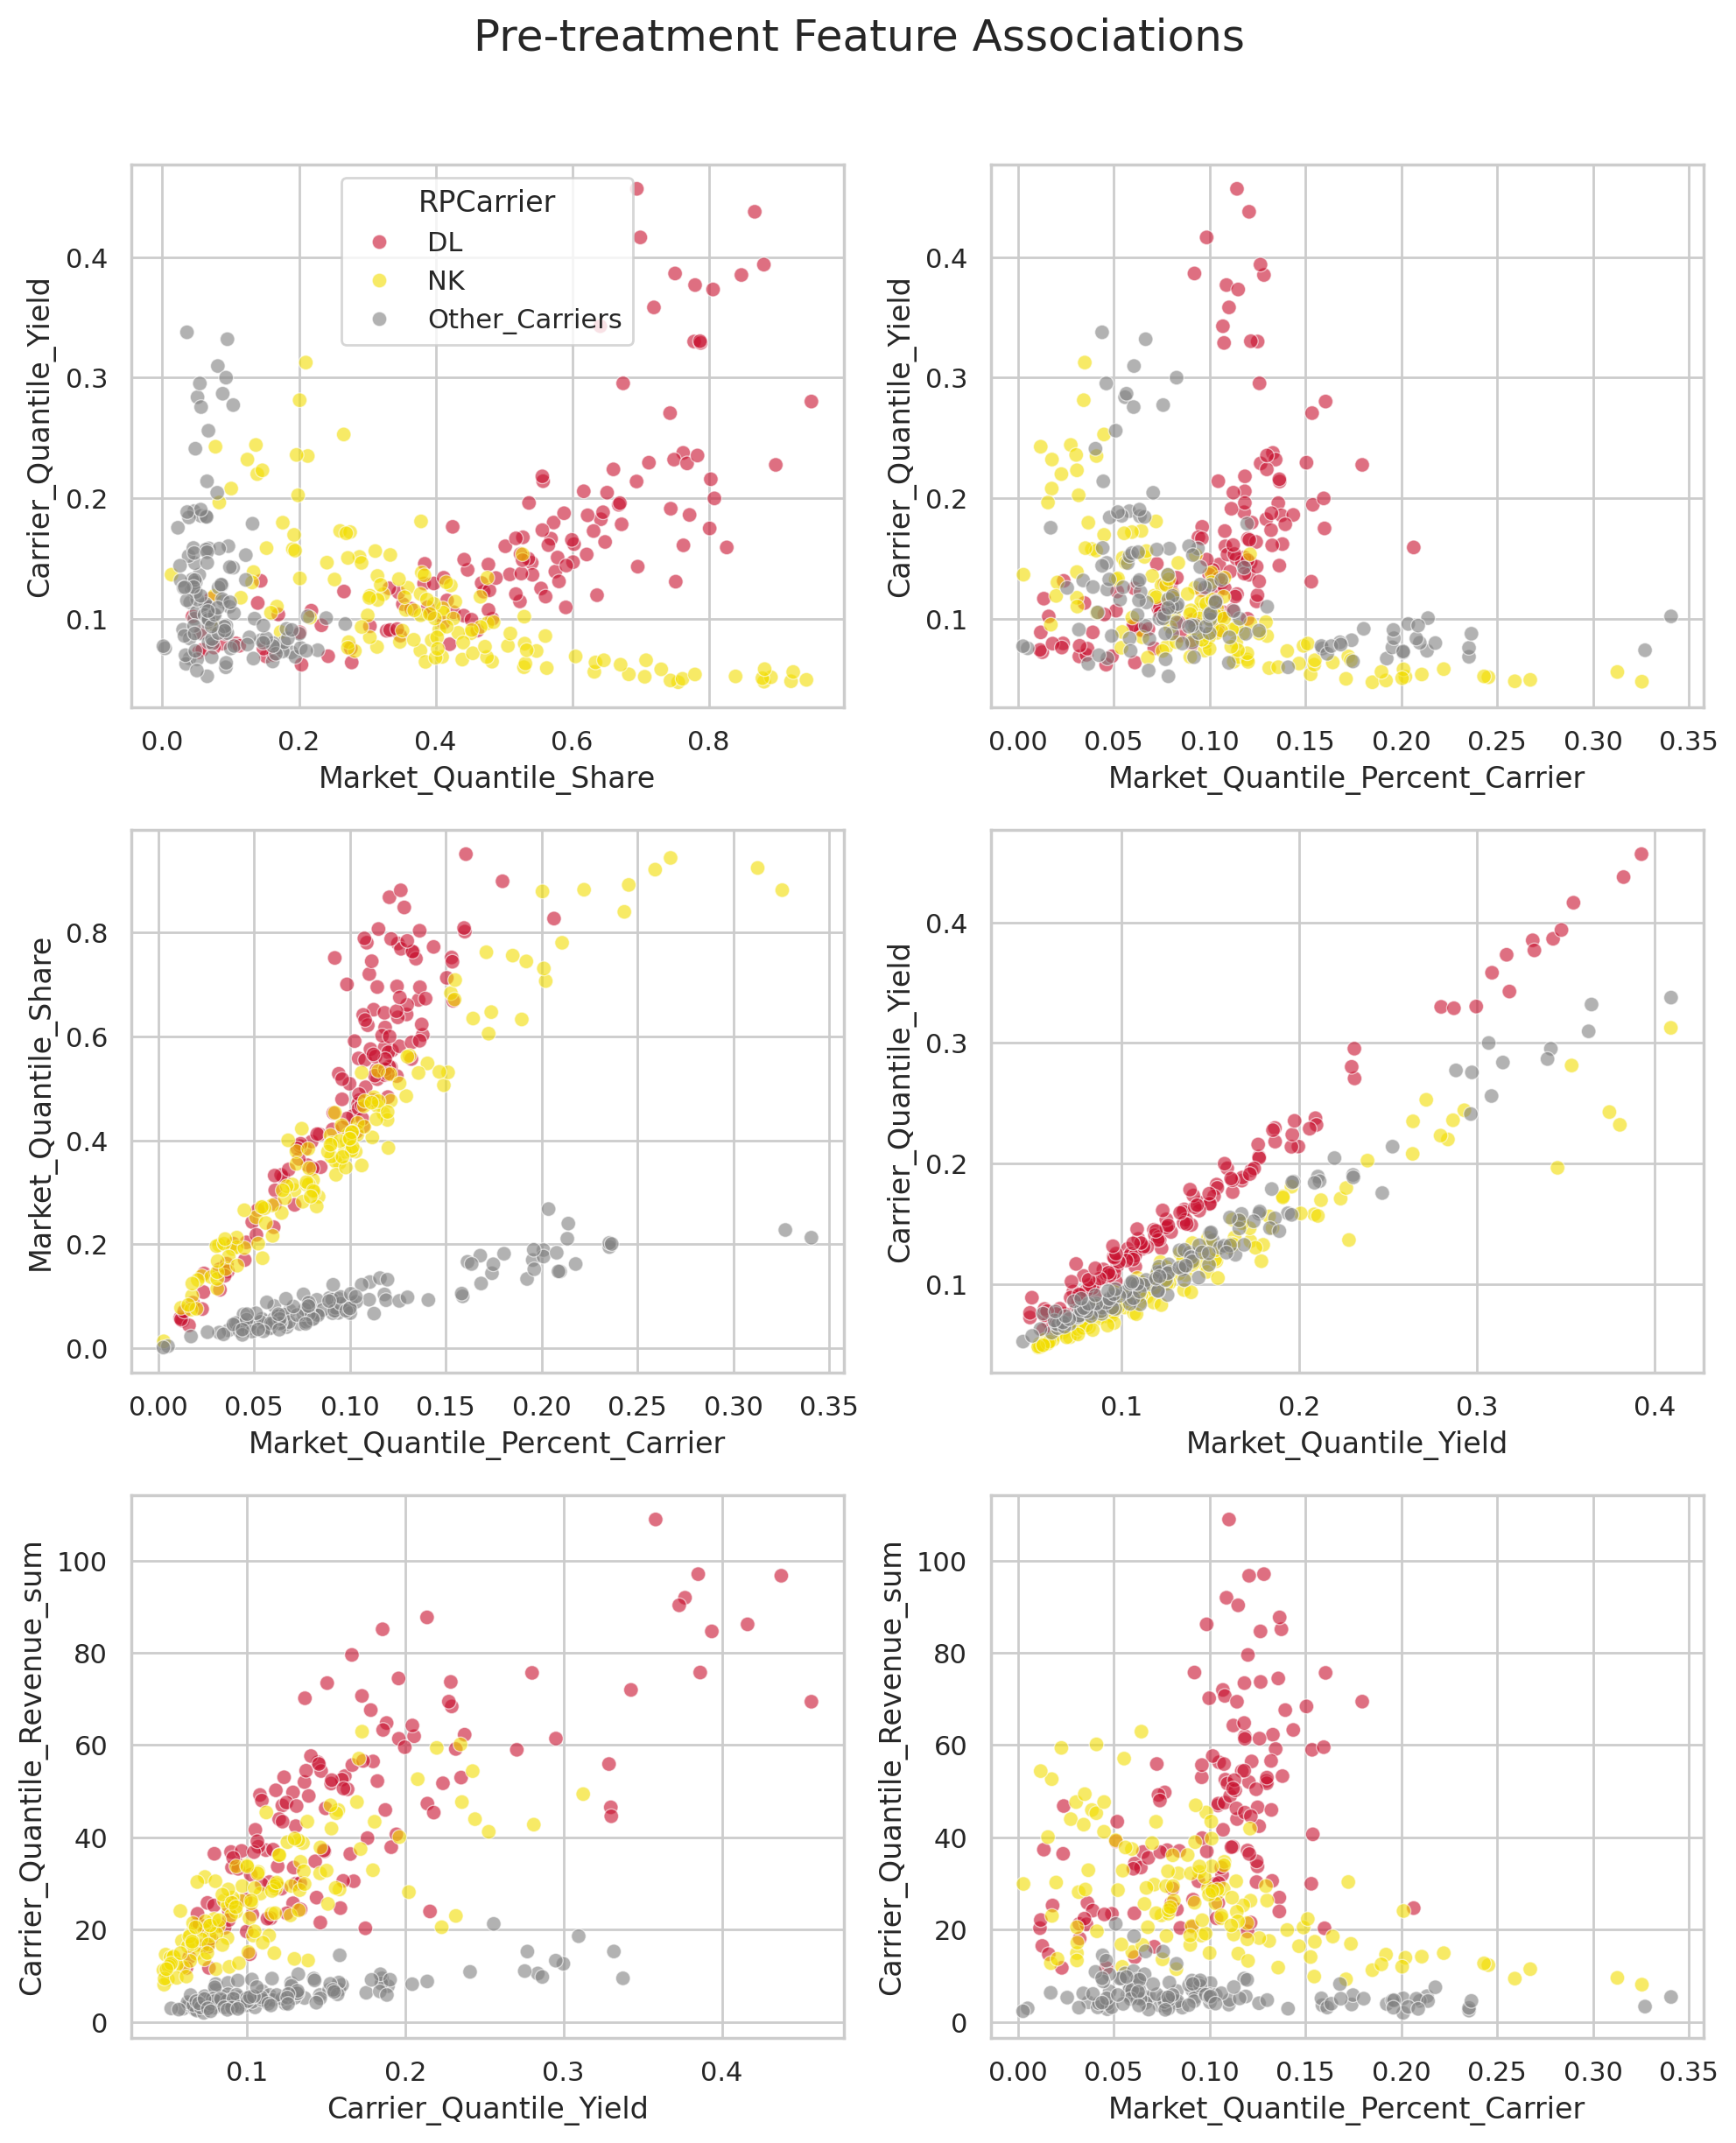

In [16]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10, 12))

sns.scatterplot(
    data=pre_fll_df,
    x='Market_Quantile_Share',
    y='Carrier_Quantile_Yield',
    hue='RPCarrier',
    hue_order=['DL', 'NK', 'Other_Carriers'],
    palette=['#C8102E', '#F2DD00', 'gray'],
    alpha=.6,
    ax=ax[0, 0]
)

sns.scatterplot(
    data=pre_fll_df,
    x='Market_Quantile_Percent_Carrier',
    y='Carrier_Quantile_Yield',
    hue='RPCarrier',
    hue_order=['DL', 'NK', 'Other_Carriers'],
    palette=['#C8102E', '#F2DD00', 'gray'],
    alpha=.6,
    legend=False,
    ax=ax[0, 1]
)

sns.scatterplot(
    data=pre_fll_df,
    x='Market_Quantile_Percent_Carrier',
    y='Market_Quantile_Share',
    hue='RPCarrier',
    hue_order=['DL', 'NK', 'Other_Carriers'],
    palette=['#C8102E', '#F2DD00', 'gray'],
    alpha=.6,
    legend=False,
    ax=ax[1, 0]
)

sns.scatterplot(
    data=pre_fll_df,
    x='Market_Quantile_Yield',
    y='Carrier_Quantile_Yield',
    hue='RPCarrier',
    hue_order=['DL', 'NK', 'Other_Carriers'],
    palette=['#C8102E', '#F2DD00', 'gray'],
    alpha=.6,
    legend=False,
    ax=ax[1, 1]
)

sns.scatterplot(
    data=pre_fll_df,
    x='Carrier_Quantile_Yield',
    y='Carrier_Quantile_Revenue_sum',
    hue='RPCarrier',
    hue_order=['DL', 'NK', 'Other_Carriers'],
    palette=['#C8102E', '#F2DD00', 'gray'],
    alpha=.6,
    legend=False,
    ax=ax[2, 0]
)

sns.scatterplot(
    data=pre_fll_df,
    x='Market_Quantile_Percent_Carrier',
    y='Carrier_Quantile_Revenue_sum',
    hue='RPCarrier',
    hue_order=['DL', 'NK', 'Other_Carriers'],
    palette=['#C8102E', '#F2DD00', 'gray'],
    alpha=.6,
    legend=False,
    ax=ax[2, 1]
)

fig.suptitle('Pre-treatment Feature Associations', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

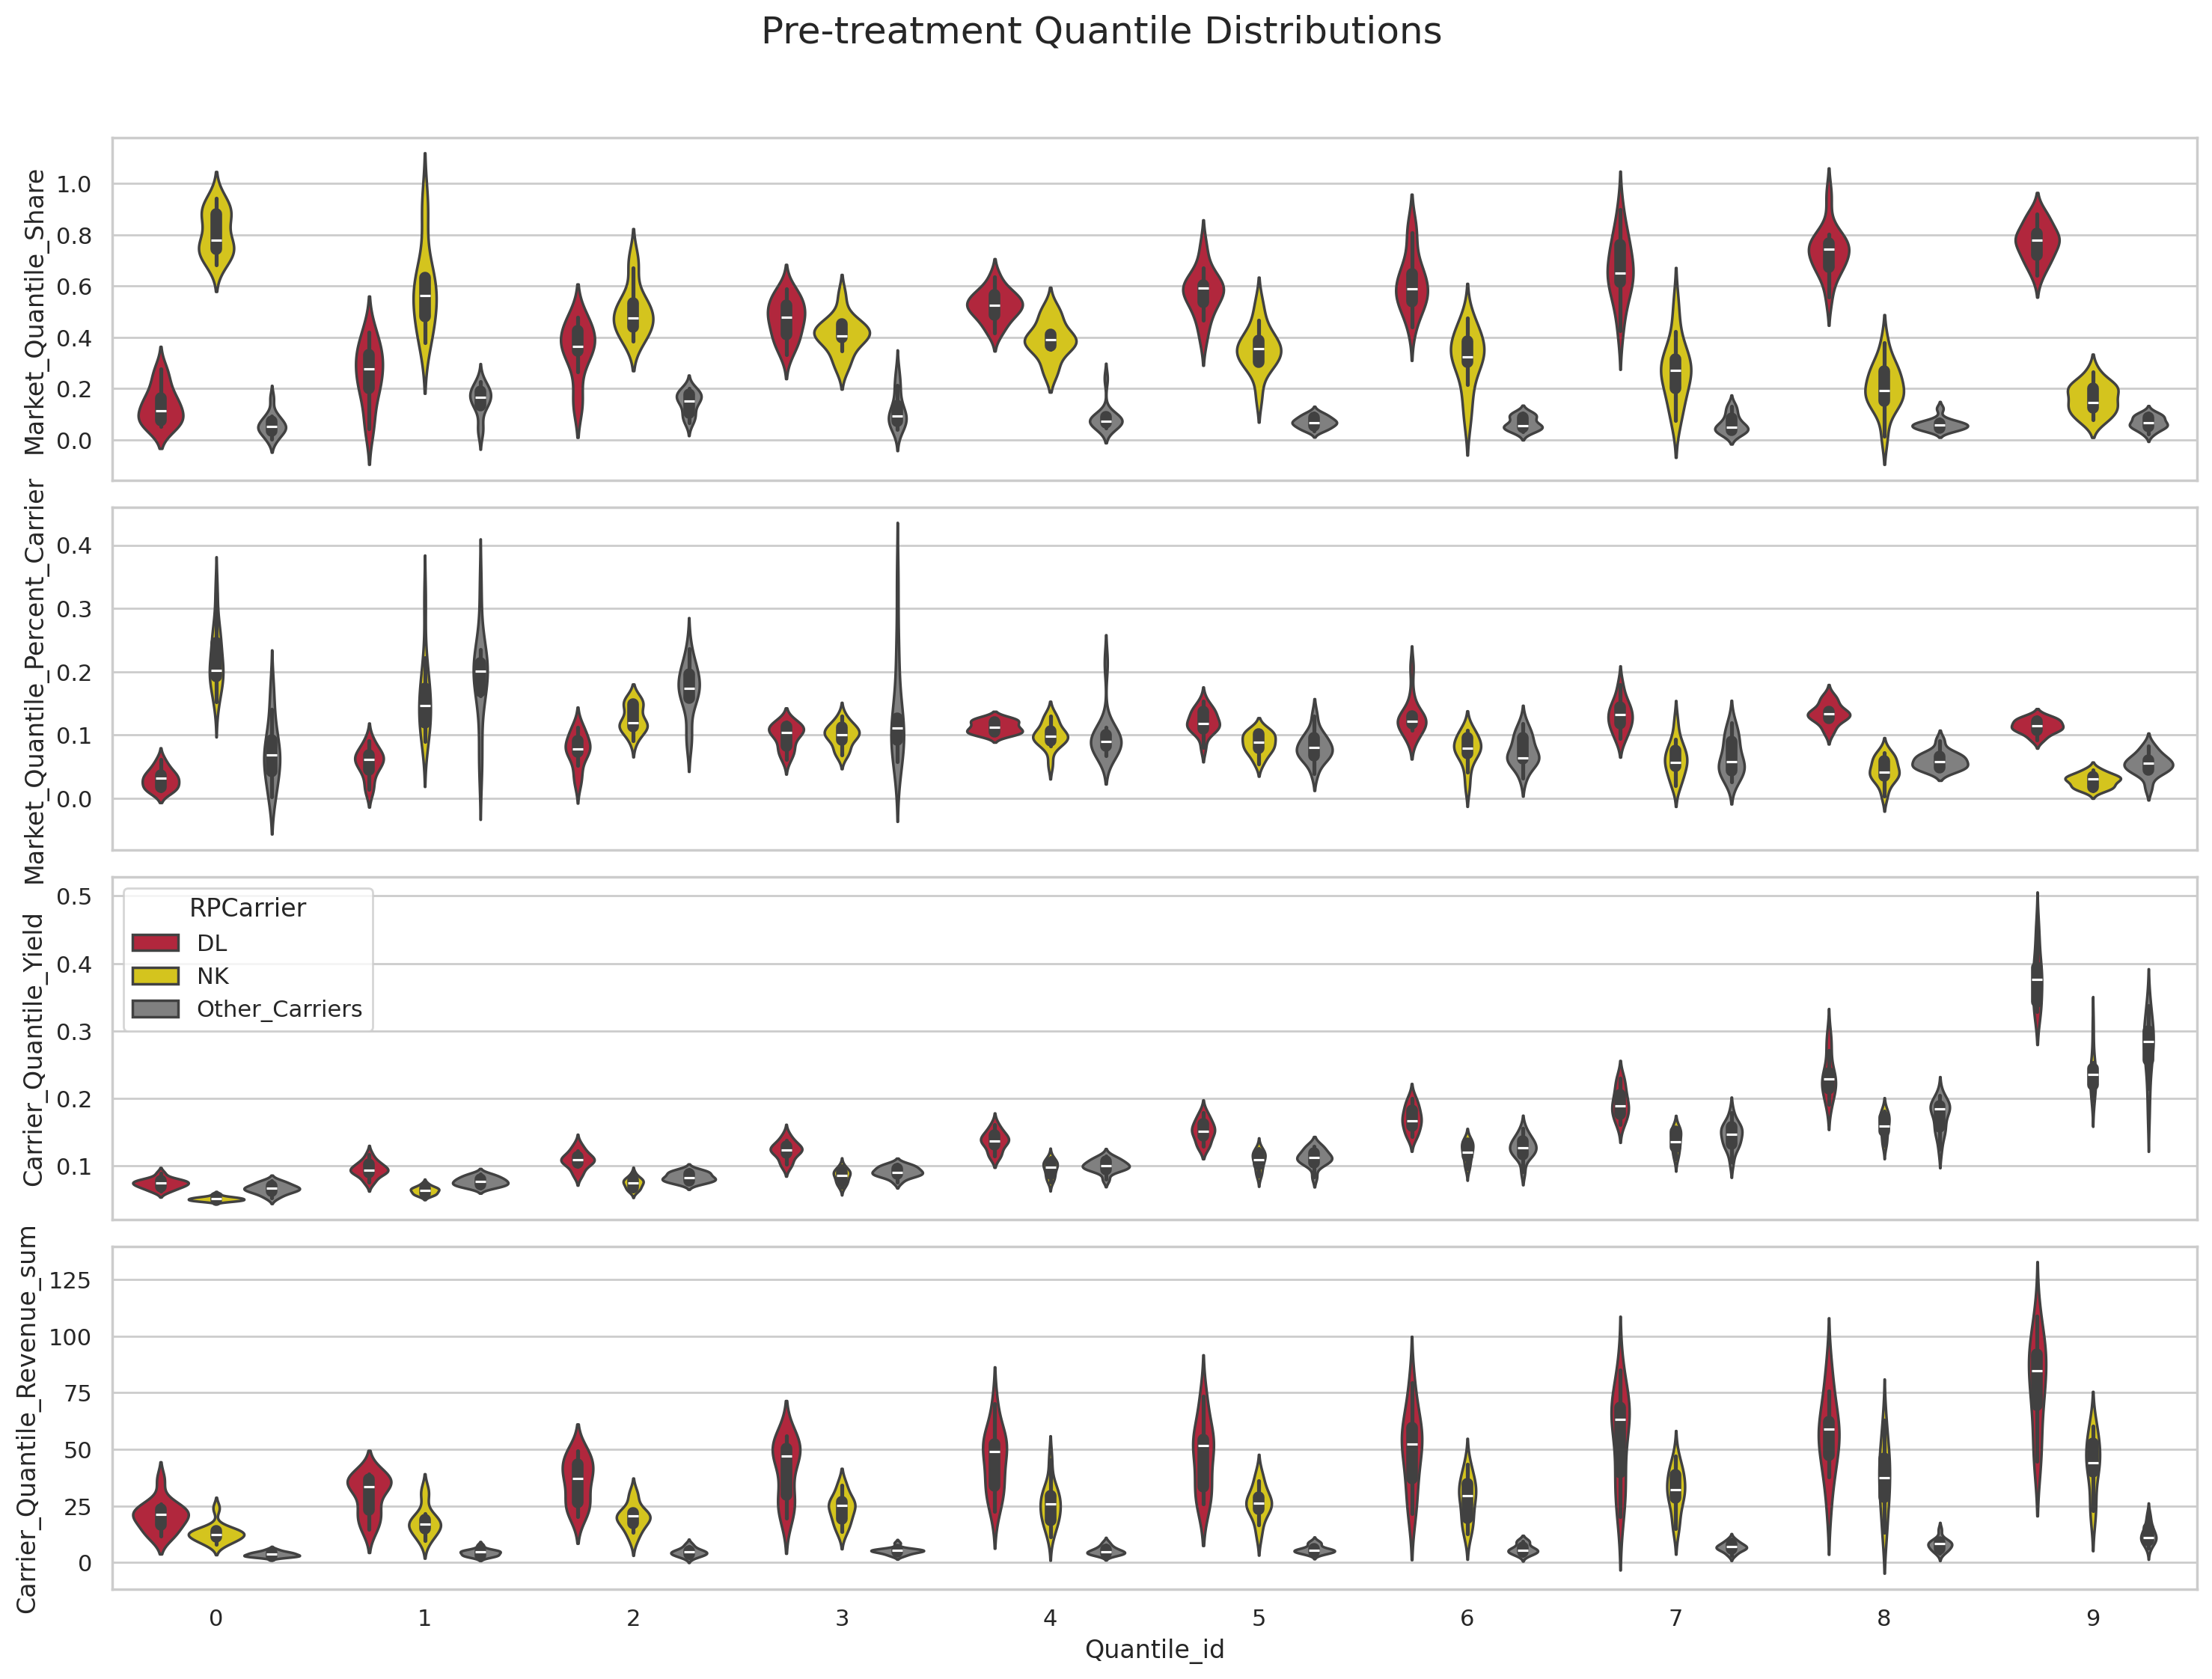

In [17]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 11), sharex=True)

sns.violinplot(
    data=pre_fll_df,
    x='Quantile_id',
    y='Market_Quantile_Share',
    hue='RPCarrier',
    hue_order=['DL', 'NK', 'Other_Carriers'],
    palette=['#C8102E', '#F2DD00', 'gray'],
    legend=False,
    ax=ax[0]
)

sns.violinplot(
    data=pre_fll_df,
    x='Quantile_id',
    y='Market_Quantile_Percent_Carrier',
    hue='RPCarrier',
    hue_order=['DL', 'NK', 'Other_Carriers'],
    palette=['#C8102E', '#F2DD00', 'gray'],
    legend=False,
    ax=ax[1]
)

sns.violinplot(
    data=pre_fll_df,
    x='Quantile_id',
    y='Carrier_Quantile_Yield',
    hue='RPCarrier',
    hue_order=['DL', 'NK', 'Other_Carriers'],
    palette=['#C8102E', '#F2DD00', 'gray'],
    ax=ax[2]
)

sns.violinplot(
    data=pre_fll_df,
    x='Quantile_id',
    y='Carrier_Quantile_Revenue_sum',
    hue='RPCarrier',
    hue_order=['DL', 'NK', 'Other_Carriers'],
    palette=['#C8102E', '#F2DD00', 'gray'],
    legend=False,
    ax=ax[3]
)

fig.suptitle('Pre-treatment Quantile Distributions', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

## Modeling


**Data Recap**

The dtw_fll_df is aggregated into 10 deciles (Quantiles 0-9) based on the market yield for each quarter. These 10 quantiles represent an approximation of the market fare structure for each quarter. By totaling the yield for each carrier's contribution to each quantile, we obtain `Market_Quantile_Revenue_sum`. In other words, this is the total revenue earned per passenger mile for each carrier in each market-level quantile.

**Modeling Goals**

In the second analysis, detailed in `airline_synthetic_control.ipynb`, the goal is to estimate the average treatment effect on the treated (ATT) routes using a Bayesian Synthetic Control method. It simultaneously creates a synthetic control for both KPIs: yield and market share. In this analysis, we will use `Market_Quantile_Revenue_sum` because it can be roughly considered an approximation of both yield and market share. Using `Market_Quantile_Revenue_sum` provides a clearer view of how fare structures change in response to Deltas' move, compared to the analysis in `airline_synthetic_control.ipynb`.


### Delta Revenue Model

In [18]:
az.style.use("arviz-darkgrid")

In [19]:
time_id = pre_dl_fll_df.index.to_numpy()
quarter_id = pre_dl_fll_df['Quarter_id'].to_numpy()
quantile_id = pre_dl_fll_df['Quantile_id'].to_numpy()
q_revenue_data = pre_dl_fll_df['Market_Quantile_Revenue_sum'].to_numpy()

print(time_id.shape)
print(quarter_id.shape)
print(quantile_id.shape)
print(q_revenue_data.shape)

coords = {
          'quarter_dim': pre_dl_fll_df['Quarter'].unique(),
          'quantile_dim': pre_dl_fll_df['Quantile_id'].astype('int').unique(),
}
display(coords)

(130,)
(130,)
(130,)
(130,)


{'quarter_dim': array([4, 1, 2, 3], dtype=uint8),
 'quantile_dim': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])}

In [20]:
with pm.Model(coords=coords) as dl_model:
    # Data containers
    time = pm.Data('time', time_id, dims='t')
    quarter = pm.Data('quarter', quarter_id, dims='t')
    quantile = pm.Data('quantile', quantile_id, dims='t')
    q_revenue = pm.Data('q_revenue', q_revenue_data, dims='t')

    # Priors
    intercept = pm.Normal('intercept', mu=50, sigma=25)
    quarter_mu = ZeroSumNormal("quarter mu", sigma=20, dims="quarter_dim")
    quantile_mu = ZeroSumNormal("quantile mu", sigma=30, dims="quantile_dim")

    # Linear_trend
    linear_trend = pm.Normal('linear_trend', mu=0.05, sigma=0.25)

    # The actual linear model
    mu = pm.Deterministic(
        "mu",
        intercept + (linear_trend * time) +
        quarter_mu[quarter] +
        quantile_mu[quantile],
        dims="t",
    )
    sigma = pm.HalfNormal("sigma", 15)

    # Likelihood
    pm.TruncatedNormal("obs", mu=mu, sigma=sigma, lower=0, observed=q_revenue, dims="t")

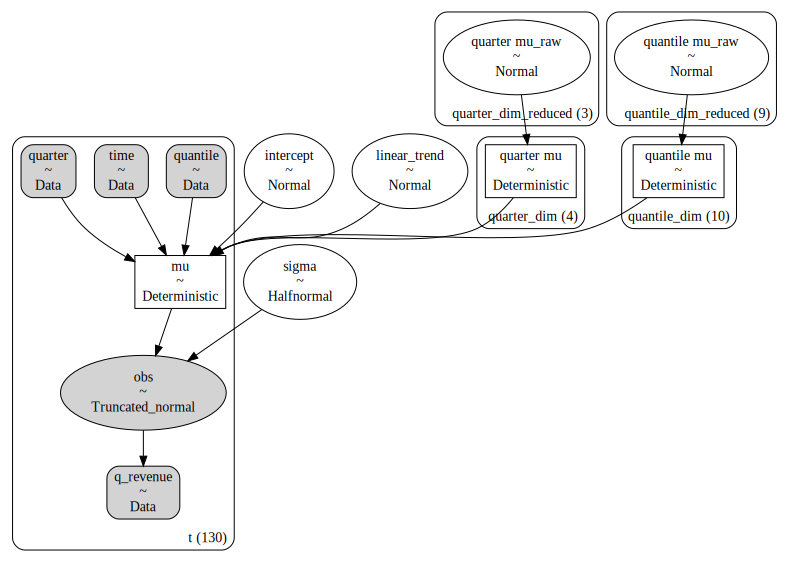

In [21]:
pm.model_to_graphviz(dl_model)

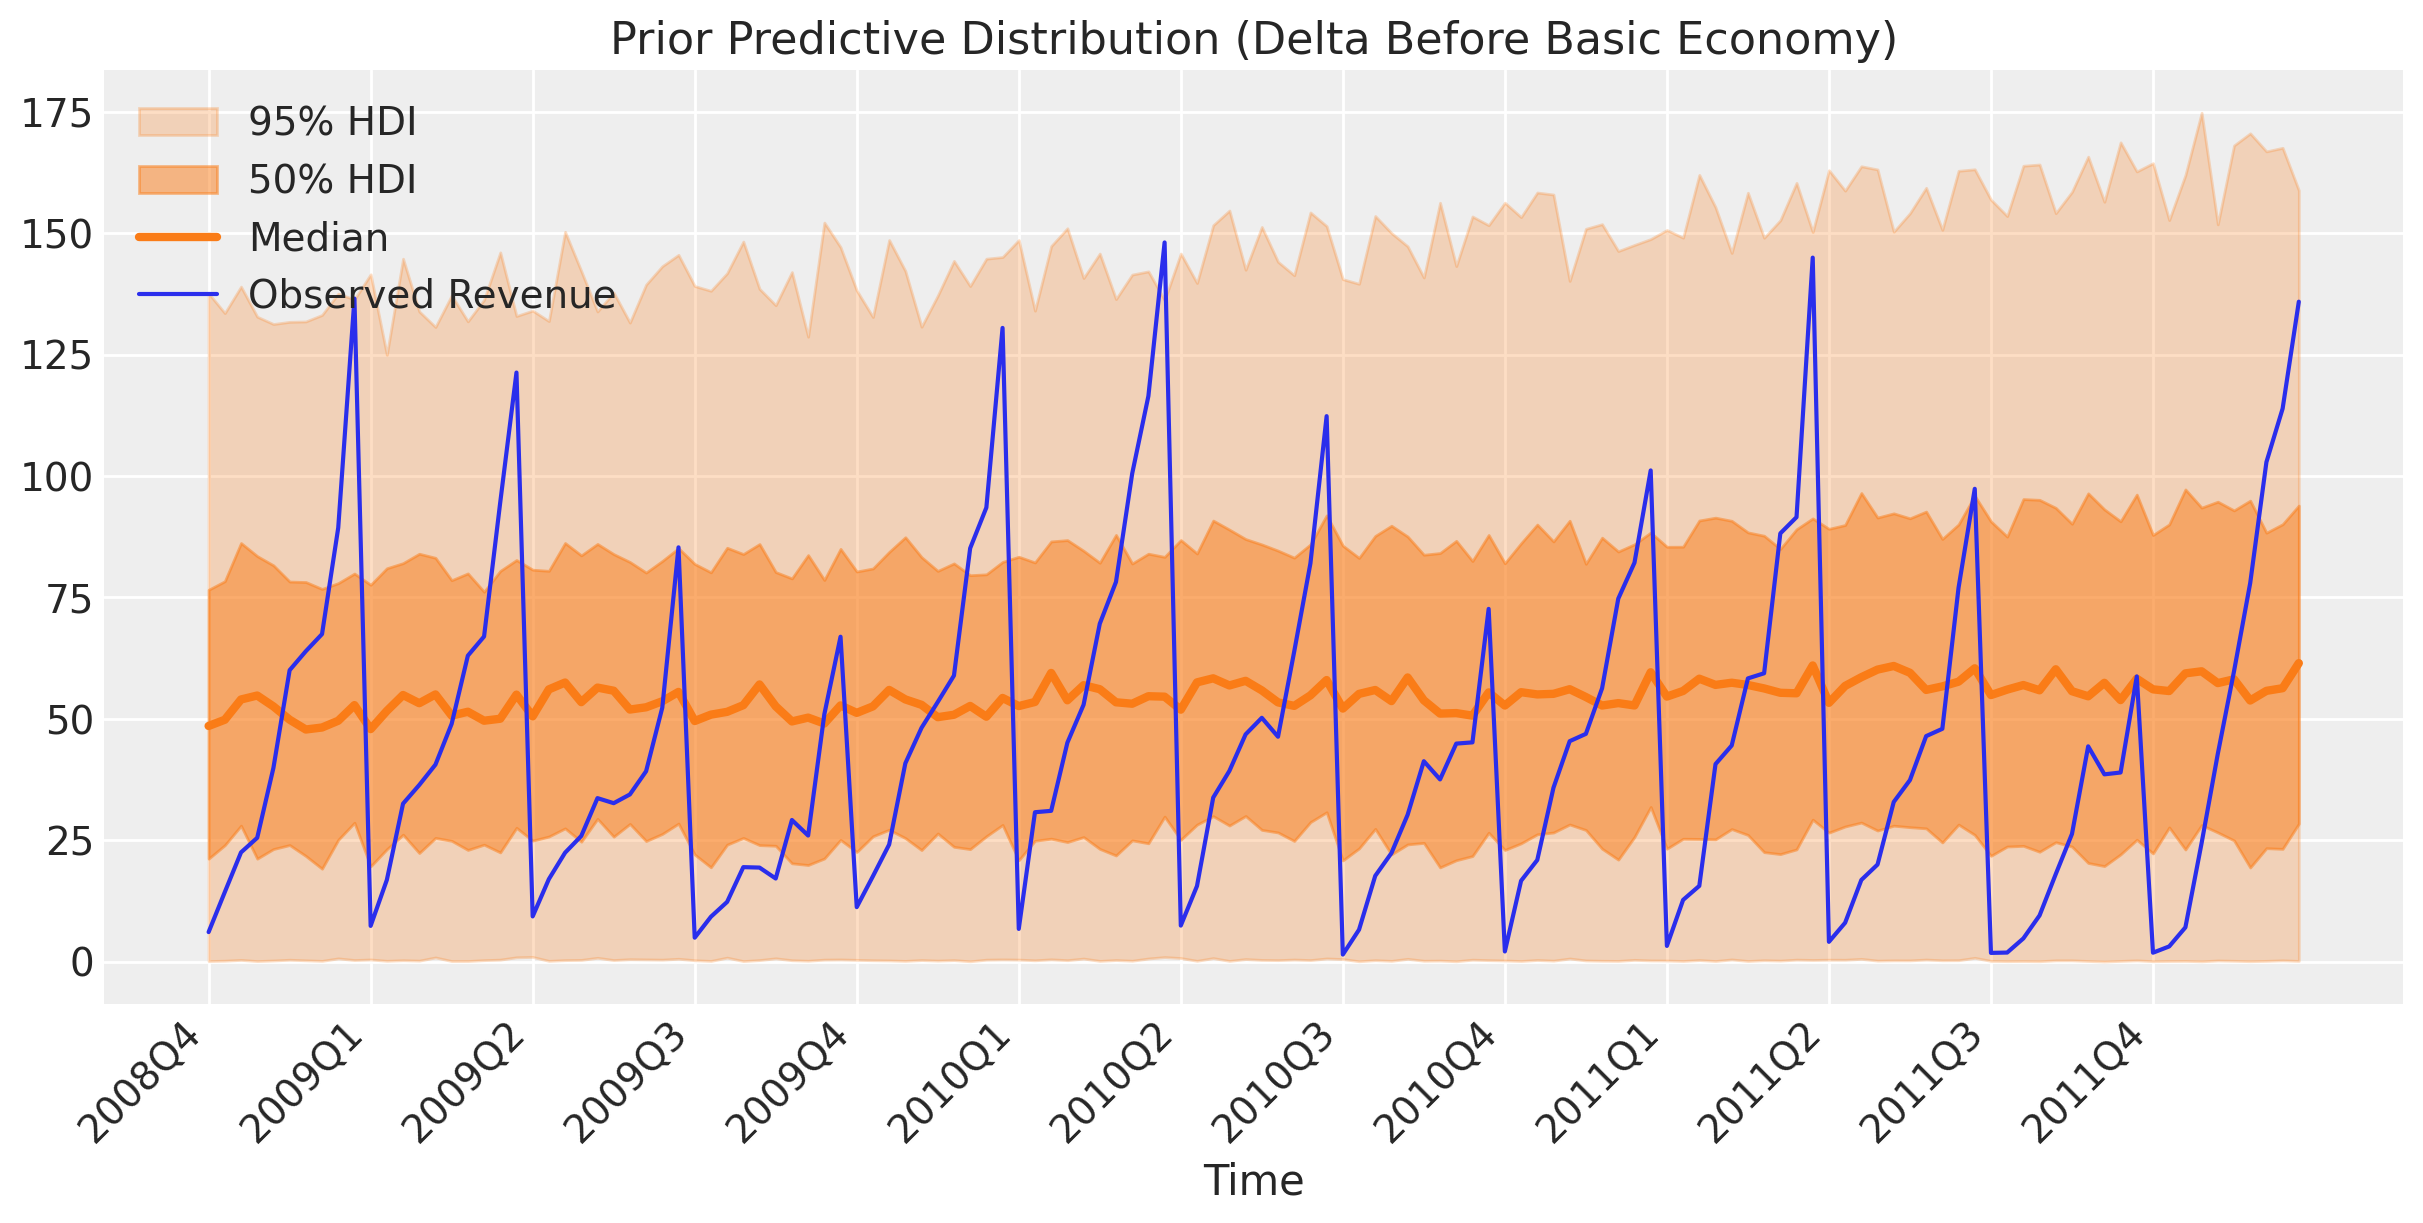

In [22]:
with dl_model:
    dl_idata = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

fig, ax = plt.subplots(
    figsize=(12, 6),
)

plot_xY(pre_dl_fll_df['Time_Str'], time_id, dl_idata.prior_predictive["obs"], ax)

ax.plot(time_id, pre_dl_fll_df["Market_Quantile_Revenue_sum"], label="Observed Revenue")
ax.set(title="Prior Predictive Distribution (Delta Before Basic Economy)")
ax.legend();

The distribution of the models observations is centered on the actual observations but has more spread. This is useful as we know the priors are not too restrictive and are unlikely to systematically influence our posterior predictions upwards or downwards.

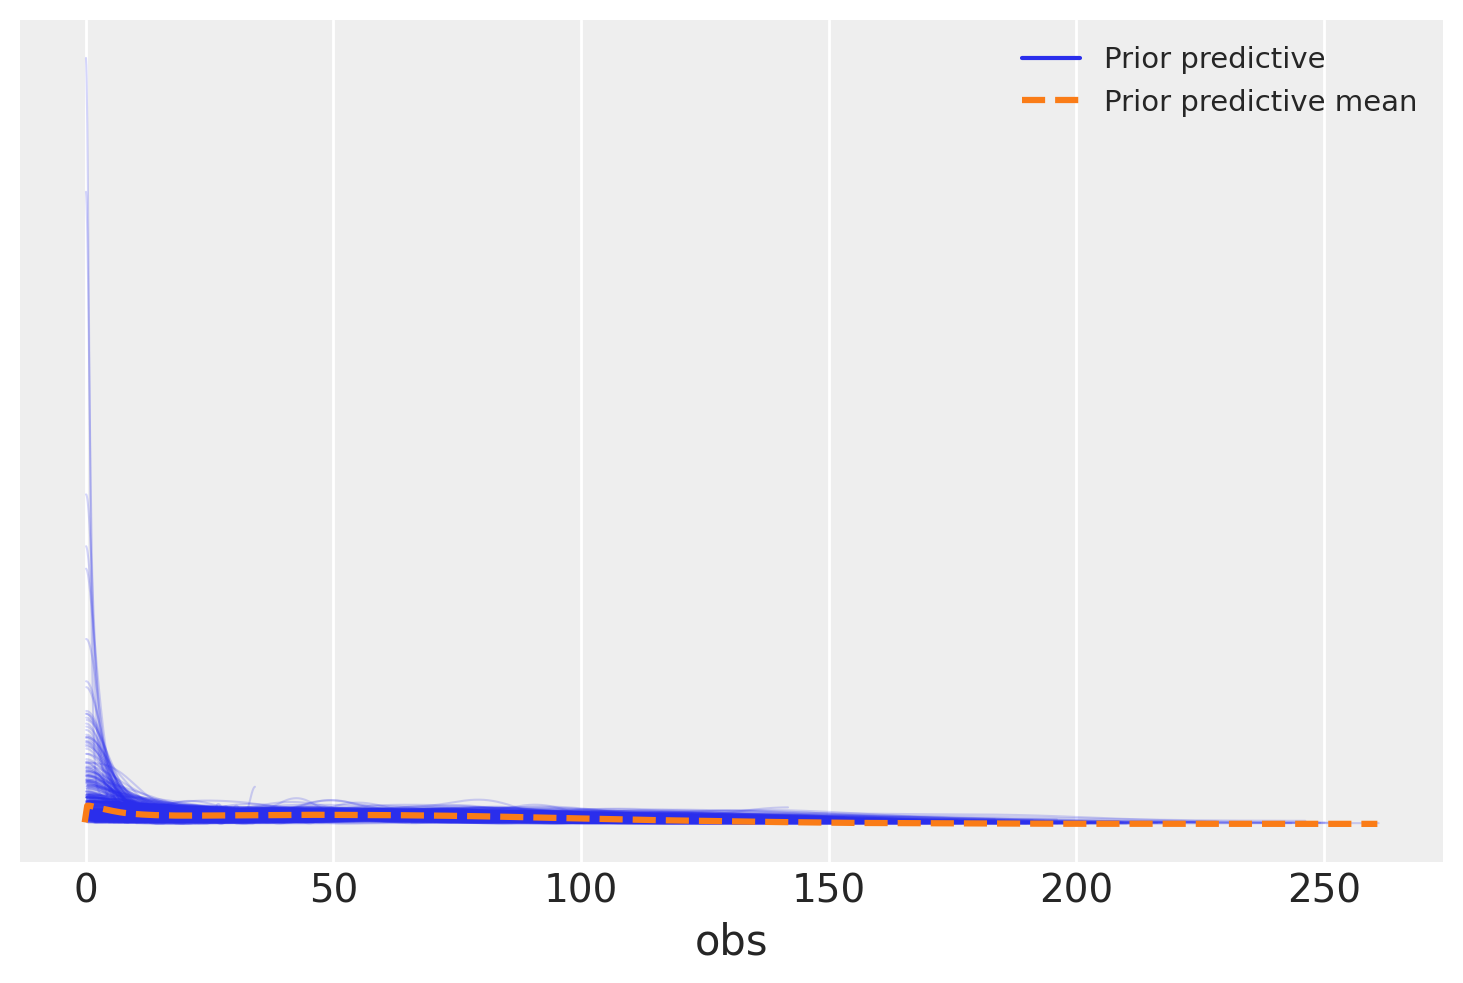

In [23]:
az.plot_ppc(dl_idata, group="prior");

In [ ]:
with dl_model:
    dl_idata.extend(pm.sample(random_seed=RANDOM_SEED))

In [ ]:
az.summary(
    dl_idata,
    var_names=[
        'intercept',
        'linear_trend',
        'quarter mu',
        'quantile mu',
        'sigma'
    ]
)

In [ ]:
az.plot_energy(dl_idata)

In [ ]:
az.plot_trace(dl_idata, var_names=["~mu", "~quarter mu_raw", "~quantile mu_raw"]);

In [ ]:
az.plot_forest(dl_idata.posterior, var_names=['quantile mu', 'quarter mu'], figsize=(8,8));

In [ ]:
with dl_model:
    dl_idata.extend(pm.sample_posterior_predictive(dl_idata, random_seed=RANDOM_SEED))

fig, ax = plt.subplots(
    figsize=(12, 6),
)

plot_xY(pre_dl_fll_df['Time_Str'], time_id, dl_idata.posterior_predictive['obs'], ax)

ax.plot(time_id, pre_dl_fll_df["Market_Quantile_Revenue_sum"], label="Observed Revenue")
ax.set(title="Posterior Predictive Distribution (Delta Before Basic Economy)")
ax.legend()

save_path = os.path.join(plots_folder, 'Pretreatment_Posterior_Predictive_DL.png')
plt.savefig(save_path)

plt.show()

In [ ]:
post_dl_time_id = post_dl_fll_df.index.to_numpy()
post_dl_quarter_id = post_dl_fll_df['Quarter_id'].to_numpy()
post_dl_quantile_id = post_dl_fll_df['Quantile_id'].to_numpy()

In [ ]:
with dl_model:
    pm.set_data(
        {
            'time': post_dl_time_id,
            'quarter': post_dl_quarter_id,
            'quantile': post_dl_quantile_id,
        }
    )
    counterfactual = pm.sample_posterior_predictive(
        dl_idata, var_names=['obs'], random_seed=RANDOM_SEED
    )

In [ ]:
fig, ax = plt.subplots(
    figsize=(12, 6),
)

plot_xY(post_dl_fll_df['Time_Str'], post_dl_time_id, counterfactual.posterior_predictive["obs"], ax)

ax.plot(post_dl_time_id, post_dl_fll_df["Market_Quantile_Revenue_sum"], label="Observed Revenue")
ax.set(title="Counterfactual: Posterior Predictive (Delta After Basic Economy)")
ax.legend()

save_path = os.path.join(plots_folder, 'Counterfactual_Posterior_Predictive_DL.png')
plt.savefig(save_path)

plt.show()

In [ ]:
post_q_revenue= xr.DataArray(
     post_dl_fll_df["Market_Quantile_Revenue_sum"].to_numpy(),
     dims=["t"]
)
diff_q_revenue = post_q_revenue - counterfactual.posterior_predictive["obs"]

cumsum = diff_q_revenue.cumsum(dim="t")



In [ ]:
fig, ax = plt.subplots(
    figsize=(12, 6),
)

plot_xY(
    post_dl_fll_df['Time_Str'],
    post_dl_time_id,
    diff_q_revenue.transpose(..., "t"),
    ax
)

ax.axhline(y=0, color="k")
ax.set(title="Difference Between Observed and Counterfactual (Delta After Basic Economy)");

In [ ]:
fig, ax = plt.subplots(
    figsize=(12, 6),
    sharex=True,
)

plot_xY(
    post_dl_fll_df['Time_Str'],
    post_dl_time_id,
    cumsum.transpose(..., "t"),
    ax
)

ax.axhline(y=0, color="k")
ax.set(title="Cumulative Revenue Difference (Delta After Basic Economy)")

save_path = os.path.join(plots_folder, 'Cumulative_Revenue_DL.png')
plt.savefig(save_path)

plt.show()

### Spirit Revenue Model

In [ ]:
pre_nk_time_id = pre_nk_fll_df.index.to_numpy()
pre_nk_quarter_id = pre_nk_fll_df['Quarter_id'].to_numpy()
pre_nk_quantile_id = pre_nk_fll_df['Quantile_id'].to_numpy()
pre_nk_q_revenue_data = pre_nk_fll_df['Market_Quantile_Revenue_sum'].to_numpy()

print(pre_nk_time_id.shape)
print(pre_nk_quarter_id.shape)
print(pre_nk_quantile_id.shape)
print(pre_nk_q_revenue_data.shape)

coords = {
          'quarter_dim': pre_nk_fll_df['Quarter'].unique(),
          'quantile_dim': pre_nk_fll_df['Quantile_id'].astype('int').unique(),
}
display(coords)

In [ ]:
with pm.Model(coords=coords) as nk_model:
    time = pm.Data('time', pre_nk_time_id, dims='t')
    quarter = pm.Data('quarter', pre_nk_quarter_id, dims='t')
    quantile = pm.Data('quantile', pre_nk_quantile_id, dims='t')
    q_revenue = pm.Data('q_revenue', pre_nk_q_revenue_data, dims='t')

    intercept = pm.Normal('intercept', mu=25, sigma=7,)
    quarter_mu = ZeroSumNormal("quarter mu", sigma=7, dims="quarter_dim")
    quantile_mu = ZeroSumNormal("quantile mu", sigma=10, dims="quantile_dim")

    linear_trend = pm.Normal('linear_trend', mu=0, sigma=0.10)

    mu = pm.Deterministic(
        "mu",
        intercept + (linear_trend * time) +
        quarter_mu[quarter] +
        quantile_mu[quantile],
        dims="t",
    )
    sigma = pm.HalfNormal("sigma", 5)

    pm.TruncatedNormal("obs", mu=mu, sigma=sigma, lower=0, observed=pre_nk_q_revenue_data, dims="t")

In [ ]:
pm.model_to_graphviz(nk_model)

In [ ]:
with nk_model:
    nk_idata = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

fig, ax = plt.subplots(
    figsize=(12, 6),
)

plot_xY(pre_nk_fll_df['Time_Str'], pre_nk_time_id, nk_idata.prior_predictive["obs"], ax)

ax.plot(pre_nk_time_id, pre_nk_fll_df["Market_Quantile_Revenue_sum"], label="Observed Revenue")
ax.set(title="Prior Predictive Distribution (Spirit Before Basic Economy)")
ax.legend();

In [ ]:
with nk_model:
    nk_idata.extend(pm.sample(random_seed=RANDOM_SEED))

In [ ]:
az.summary(
    nk_idata,
    var_names=[
        'intercept',
        'linear_trend',
        'quarter mu',
        'quantile mu',
        'sigma'
    ]
)

In [ ]:
az.plot_trace(nk_idata, var_names=["~mu", "~quarter mu_raw", "~quantile mu_raw"]);

In [ ]:
with nk_model:
    nk_idata.extend(pm.sample_posterior_predictive(nk_idata, random_seed=RANDOM_SEED))


fig, ax = plt.subplots(figsize=(12, 6))

plot_xY(pre_nk_fll_df['Time_Str'], pre_nk_time_id, nk_idata.posterior_predictive["obs"], ax)

ax.plot(pre_nk_time_id, pre_nk_fll_df["Market_Quantile_Revenue_sum"], label="Observed Revenue")
ax.set(title="Posterior Predictive Distribution (Spirit Before Basic Economy)")
ax.legend()

save_path = os.path.join(plots_folder, 'Pretreatment_Posterior_Predictive_NK.png')
plt.savefig(save_path)

In [ ]:
post_nk_time_id = post_nk_fll_df.index.to_numpy()
post_nk_quarter_id = post_nk_fll_df['Quarter_id'].to_numpy()
post_nk_quantile_id = post_nk_fll_df['Quantile_id'].to_numpy()

In [ ]:
with nk_model:
    pm.set_data(
        {
            'time': post_nk_time_id,
            'quarter': post_nk_quarter_id,
            'quantile': post_nk_quantile_id,
        }
    )
    counterfactual = pm.sample_posterior_predictive(
        nk_idata, var_names=['obs'], random_seed=RANDOM_SEED
    )

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

plot_xY(post_nk_fll_df['Time_Str'], post_nk_time_id, counterfactual.posterior_predictive["obs"], ax)

ax.plot(post_nk_time_id, post_nk_fll_df["Market_Quantile_Revenue_sum"], label="Observed Revenue")
ax.set(title="Counterfactual: Posterior Predictive (Spirit After Basic Economy)")
ax.legend()

save_path = os.path.join(plots_folder, 'Counterfactual_Posterior_Predictive_NK.png')
plt.savefig(save_path)

In [ ]:
nk_post_q_revenue= xr.DataArray(
     post_nk_fll_df["Carrier_Quantile_Revenue_sum"].to_numpy(),
     dims=["t"]
)
nk_diff_q_revenue = nk_post_q_revenue - counterfactual.posterior_predictive["obs"]

nk_cumsum = nk_diff_q_revenue.cumsum(dim="t")

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

plot_xY(
    post_nk_fll_df['Time_Str'],
    post_nk_time_id,
    nk_cumsum.transpose(..., "t"),
    ax
)

ax.axhline(y=0, color="k")
ax.set(title="Cumulative Revenue Difference (Spirit After Basic Economy)")

save_path = os.path.join(plots_folder, 'Cumulative_Revenue_NK.png')
plt.savefig(save_path)

Save models

In [ ]:
nk_idata.to_netcdf("/content/drive/MyDrive/AirlineData/counterfactual_trend_models/trend_nk_model.nc")

In [ ]:
dl_idata.to_netcdf("/content/drive/MyDrive/AirlineData/counterfactual_trend_models/trend_dl_model.nc")

In [ ]:
dl_model_graph = pm.model_to_graphviz(dl_model)
dl_model_graph.render(filename='/content/drive/MyDrive/AirlineData/counterfactual_trend_models/dl_model_graph', format='png', view=False)

In [ ]:
nk_model_graph = pm.model_to_graphviz(nk_model)
nk_model_graph.render(filename='/content/drive/MyDrive/AirlineData/counterfactual_trend_models/nk_model_graph', format='png', view=False)